# Russian Layout Optimization with Bigrams

In [1]:
from lib import Corpus, Keyboard, Layout, Result, STANDARD_KBD, std_key_shape, STD_EXTRA_KEYS, ERGODOX, compare, BASE_KEYS_RU
import pandas as pd

# Contents

- [How this all works](#hiw)
- [How to test your layout](#how-to-test-your-layout)
- [Initialization and code](#init)
    - [Loading sample texts](#loading-texts)
        - [Some stats on bigrams](#some-stats)
    - [The code with the scoring rules](#scoring-code)
- [Comparing existing and my new layouts](#layouts)
- [Side-to-side comparisons of the best](#side-to-side)
- [Final standings](#standings)
- [Test your layout here](#your-layout)
    - [Compare with others](#compare)
    - [Output statistics in CSV](#output-statistics)
    - [Simple statistics of costs](#simple-stats)
    - [Where do letters want to move?](#letters-move)
- [Is Ergodox better?](#is-ergodox-better)
- [Heatmaps](#heatmaps)


## How This All Works <a name="hiw">

The code is organized in simple to use classes.
    
```
Corpus ------------------------------------------------> | Result
  .bigrams                                        /----> |   .score
                                                 /           .bigrams (w/ scores)
Keyboard ------------------>  Layout -----------/            .layout
  .keymap                       .keyboard                    .corpus
  (fingers & penalties)         .keymap
                                (keys w/ positions)
```

* `Corpus` stores bigrams dataframe, with frequencies and basic info about the letters for categorial analysis.
* `Keyboard` stores a dict: {(row, column): (finger, monogram penalty, ...)}
* To make a new Keyboard, provide it with fingers and penalties strings (see `STANDARD_KBD` and `ERGODOX` below).
* `Layout` takes keyboard, makes the dict a dataframe and adds keys to it.
* `Result` stores score and bigrams costs dataframes.
* `Result` can compare itself with another one, or better call `compare(results_dict, key1, key2)` to do things automatically.

## Testing Your Layout <a name="how-to-test-your-layout">

1. Run the cell with the code to make `CORP` and `STANDARD_KBD` (or another one).
1. Go to [Insert Your Layout](#your-layout) section.
2. Modify the layout, maintaining columns' positions, so that they match `STANDARD_KBD.fingers`.
3. Run the code & see the score.
4. Compare your layout to another one in the cells below that.

## Loading Sample Texts <a name="loading-texts">

This is a sample from Strugatski brothers' "Inhabited Island" and Michail Bulgakov's "White Guard", roughly 500K of characters. Compared to my own texts assembled in 300K chars, some letters differ slightly: letter И (i) is much less popular. I don't know what to do with this.

In [2]:
CORP = Corpus.from_path('../sampletexts.txt', 'sample1.txt', 'sample2.txt')

# Some stats on bigrams <a name="some-stats">

## Vowels outer or inner?

Negative = wants more to be on outer keys, positive = more to inner.

In [3]:
CORP.bigrams

bigram   num l1 l2 t1 t2      freq
0        ¶м   159  ¶  м  -  c  0.000174
1        мо  3241  м  о  c  v  0.003554
2        ож  1890  о  ж  v  c  0.002073
3        же  2825  ж  е  c  v  0.003098
4        ет  5188  е  т  v  c  0.005689
...     ...   ... .. .. .. ..       ...
2682     oн     1  o  н  -  c  0.000001
2683     нa     1  н  a  c  -  0.000001
2684     еp     1  е  p  v  -  0.000001
2685     yг     1  y  г  -  c  0.000001
2686     гy     1  г  y  c  -  0.000001

[2687 rows x 7 columns]

In [4]:
CORP.bigrams[(CORP.bigrams.t1 != '-') & (CORP.bigrams.t2 != '-')].groupby('l2').agg({'num': 'sum'}).sort_values('num', ascending=False)


num
l2       
о   71951
е   58480
а   54526
и   44490
т   42842
н   34441
р   30361
л   28373
с   26001
в   19409
к   17751
м   17189
д   16076
у   15812
ы   13770
ь   13741
я   12830
з    8539
й    8514
г    8425
б    7297
ч    7212
ж    5906
х    5796
п    5654
ю    4653
ш    4591
ц    2550
щ    2470
ё    1222
ф     938
ъ     273
э     268

freq_out     freq_in      outer   frequency     outerness
ъ    2.949778    0.000000  -2.949778    2.949778 -10000.000000
ь    9.902043    0.296074  -9.605969   10.198118  -9419.354839
ы   33.544131    2.434389 -31.109742   35.978520  -8646.754038
а   70.224457   19.332561 -50.891897   89.557018  -5682.625199
п  132.904501   41.625865 -91.278636  174.530366  -5229.957276
и   86.947177   37.436961 -49.510216  124.384138  -3980.428458
у   24.771557   12.040358 -12.731198   36.811915  -3458.445040
о   92.780939   88.405618  -4.375321  181.186556   -241.481571
э    1.184298    1.458440   0.274143    2.642738   1037.344398
е   50.014639  121.960714  71.946075  171.975353   4183.510808
я    6.382048   56.023853  49.641805   62.405900   7954.665261
ё    0.065794    2.938812   2.873018    3.004607   9562.043796
ю    0.515389   35.912726  35.397337   36.428115   9717.037929
й    1.030777   93.351156  92.320379   94.381934   9781.573138

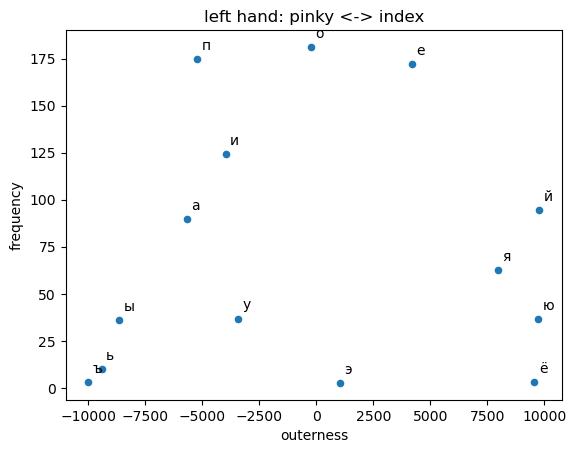

In [5]:
CORP.display_outerness("(t1 == 'v' | l1 == 'й' | l1 == 'п') & (t2 == 'v' | l2 == 'й' | l2 == 'п')", True)

## Consonants

In my layout, С (s) is the outermost (but in home column), Р (r) and Н (n) are innermost (in home column). Т comes too often before Р (-tr- is frequent like in English), so it isn't on the index finger.

freq_out     freq_in       outer   frequency    outerness
l1                                                             
щ     0.701806    5.044230   -4.342424    5.746036 -7557.251908
ц     1.173332    8.410706   -7.237374    9.584037 -7551.487414
л    21.503773   82.396404  -60.892631  103.900177 -5860.686016
р    51.900743  165.768757 -113.868014  217.669500 -5231.234257
н    62.559420  156.919423  -94.360002  219.478843 -4299.275543
т   103.461548  183.763500  -80.301952  287.225048 -2795.785133
к    43.413277   74.281773  -30.868496  117.695050 -2622.752259
м    21.624396   23.642088   -2.017692   45.266483  -445.736434
ф     2.620807    2.686601   -0.065794    5.307407  -123.966942
в    67.439165   61.660232    5.778933  129.099397   447.634418
ш    13.136930   10.176186    2.960744   23.313116  1269.990593
д    53.710086   40.200322   13.509764   93.910408  1438.580103
х     8.224288    5.680242    2.544047   13.904530  1829.652997
г    27.589746   11.963598   15.626148   39.553344  3950.651511
ж    21.942401    7.928214   14.014187   29.870615  4691.629956
с   241.541868   86.333097  155.208771  327.874964  4733.779264
ч    39.970042   11.042478   28.927564   51.012520  5670.679278
п    81.223072   21.536670   59.686402  102.759742  5808.344894
б    30.276347    5.680242   24.596105   35.956589  6840.500152
з    55.508464    4.210836   51.297628   59.719300  8589.790672
й    19.815052    0.010966   19.804086   19.826018  9988.938053

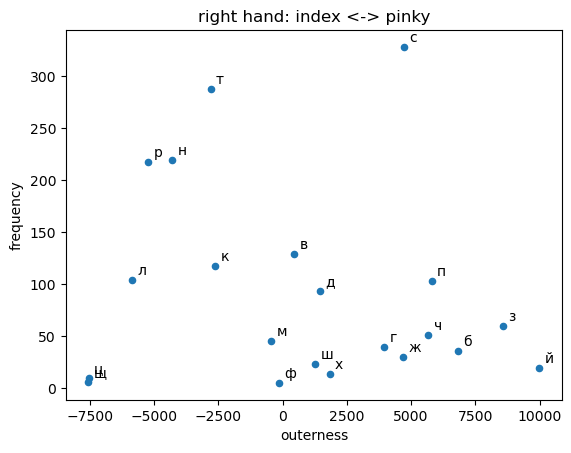

In [6]:
CORP.display_outerness("t1 == 'c' & t2 == 'c'")

Outputting the bigrams to Excel file, to see stats for each letter -- what letters come before it, and what ones come after.

In [7]:
BG = CORP.bigrams
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_before', 'prev'], fill_value=0)
dg2['dir'] = 'after'
pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}).pivot_table('num', 'letter', ['dir', 'kind_after', 'next'], fill_value=0)
dg3 = pd1.join(pd2)
dg3

dg3.melt(ignore_index=False).rename(
    columns={'variable_0': 'dir', 'variable_1': 'kind', 'variable_2': 'other', 'value': 'num'}
).reset_index().to_csv('all-letters-melt.csv')

# How Standard Keyboard is Really Used

In [8]:
real_kbd = Keyboard('real fingers', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
987643 422389
864223 43124689
 21002 2001246
 42114 411224
0
''',
std_key_shape, STD_EXTRA_KEYS)

# Layouts <a name="layouts">

## Rules:

1. Spaces/linebreaks ARE SIGNIFICANT! (Except at the beginning and end of the whole string -- those are stripped.)
2. Two linebreaks = new level (Shift, AltGr), except for start and end of the whole string.
3. Rows must be in the same order.
4. Letters positions must match those in `FINGERS` and `POS_PENALTY` strings of th keyboard (`STANDARD_KBD` by default).
5. Backslash (`\`) requires Python's raw string syntax: `r''`. Otherwise, duplicate it -- but it creates a lot of confusion with positions.
6. `∅` means no letter at all (or same letter as in lower level). Currently, we don't compute penalties for Shift/AltGr.
7. `¶` means Enter key, and every linebreak in text is treated as hitting this key.
8. `⌴` means space. This is irrelevant for skewed keyboards (they get 0 for any digrams with space), but will be needed for Ergodox.
9. `→` means Tab. Tabs in the text are also scored as keypresses (although in literature corpus they're absent, but if we inserted any text with tables, we'd be able to account for the tab key).
    
## How to test Ergodox and other non-standard models
    
By default, these layouts are used with standard staggered keyboard. If you want Ergodox, then instead of 1 string provide a 2-tuple:
    
```python
    'my_layout': (r'''<the layout>''', ERGODOX),
```
    
If you want different key positions, make a different `Keyboard` instance:
    
```python
    'my_layout': (r'''<the layout>''', Keyboard(<fingers>, <penalties>)),
```
    
search for `леонов` (new finger positions in standard kbd) and `optozorax` (Ergodox) in the dictionary below for examples.

In [9]:
LEONOV_KBD = Keyboard("leonov's remapping", '''
0001233 667899
0001233 667899
 001233 667899
 001233 6678
4
''',

'''
9863226 622489
8642134 431246
 421002 200124
 642114 4112
0
''',
# '''
# 3211113 311123
# 2111112 211112
#  200001 100001
#  111112 2111
# 0
# ''',
#  '''
# 4322224 422234
# 3211123 321123
#  200002 200002
#  211113 3111
# 0
# ''',
         std_key_shape, STD_EXTRA_KEYS
)

In [10]:
layouts = {
    # standard Russian layout ~1890
    'йцукен': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фывап ролджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
 ∅∅∅∅∅ ∅∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
''',

    # QWERTY transliterated ~1970
    'usphonetic': r'''
    
ю12345 67890-ь
→яверт ыуиопшщэ
 асдфг чйкл;'¶
 зхцжб нм,.%
⌴

∅!"ёЁъ Ъ?*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅:"∅
 ∅∅∅∅∅ ∅∅<>?
''',

    # Dvorak transliterated ~2000
    'rusdvorak': r'''
    
ю12345 67890шщ
→',.пы фгцрл/чэ
 аоеуи дхтнс-¶
 ;яйкь бмвжз
⌴

∅!@ё∅ъ %&*()_∅
∅∅∅∅∅∅ ∅∅∅∅∅∅?∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # "Dictor" layout 200?
    'диктор': r'''
    
ё12345 67890-=
→цья,. звкдчшщ
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

∅ъ"№;% :∅*()∅_+
∅∅∅∅?! ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 >:∅∅∅ ∅∅∅∅∅
''',

    # Zubachov's layout 2007
    'зубачёв': r'''
    
ё12345 67890-=
→фыаяъ ймрпхцщ
 гиеоу лтснзж¶
 шью.э бдвкч
⌴

∅!"№;% :\?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅,∅ ∅∅∅∅∅
''',

    # Skoropis 2014 (literally "Fastwrite") from https://cont.ws/@russkivek/93620
    # in fact, it's just a slightly Diktor with improved punctuation
    'скоропис': r'''
    
*.ёъ?! ∅-\'()∅
→цья,. звкдчшщ"
 уиеоа лнтсрй¶
 фэхыю бмпгж
⌴

%12345 67890∅∅
∅∅∅∅;: ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',

    # ANT layout 200?
    # this layout put Ъ's upper and lower case in different places,
    # which my code doesn't understand.
    # had to put the letter on one key to process
    'ант': r'''
    
\!?'"= +-*/%()
→гпрдм ыияухцжч
 внстл ьоеакз¶
 щйшб, .юэёф
⌴

_97531 02468""
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ъ∅∅∅∅∅∅
 ∅∅∅∅; :∅∅∅∅
''',
    
    # UNGVS 2019 https://ubuntu-mate.community/t/make-your-own-custom-keyboard-layout-for-linux/19733/
    'ugnvs': r'''
    
`12345 67890-=
→пдмкз буяьыг:'
 аиеол внтср,¶
 щцэюф хчжйш
⌴

~!?/$% <>*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅;"
 ∅∅∅∅∅ ∅∅∅∅∅.∅
 ∅∅∅∅∅ ∅∅∅∅


∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅ъ∅∅∅∅
 ∅∅ё∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
''',
    
    # Leonov 2023 https://habr.com/ru/articles/717912/
    # author uses chords for comma and period, here instead they're put in 3rd layer on index fingers.
'леонов': # 
('''
∅123456 7890-=
→щцклбй ъыяэфш
 чзвнтд иаоес¶
 жхпрмг ёьую
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅.∅ ∅,∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''',
LEONOV_KBD),
'леонов2': # 
('''
∅123456 7890-=
→чгкблщ ёэыяфш
 цснтрд йиаое¶
 жзпмвх ъюуь
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅,∅ ∅.∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
'леонов3': # 
('''
ъ123456 7890-=
→щчклбй ёыяэфш
 цсвнтд иаоеп¶
 жзхрмг ьую,
⌴

~!"№;%: ?*()_+
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅.
∅

∅∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅∅∅
 ∅∅∅∅∅∅ ∅∅∅∅
∅

''', LEONOV_KBD),
    
    # my layouts 2021
    'тест1': r'''
    
ё12345 67890-=
→йцуке нгшщзхъ\
 фыоап рвлджэ¶
 ячсми тьбю.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест2': r'''
    
ё12345 67890-=
→йцуюк енгбзхъ\
 ыоаия втсрпч¶
 элмдь жшщф.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест3': r'''

ё12345 67890-=
→ъцуюя ьнгбчхй\
 ыоаие втсрпз¶
 эфкмд жшщл.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест4': r'''
    
ё12345 67890-=
→ъэуюя цлнгчхй\
 оаыеи втсрпз¶
 фдьмк жшщб.
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест5': r'''
    
ё12345 67890-=
→ъуьюя йлнгчцх\
 оаыеи втсрпз¶
 .фжэд мкшщб
⌴

~!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅/
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',

    'тест6': r'''
    
/12345 67890-=
→ёъьую янвгчйцх
 оиаые лрптсз¶
 ,эфшщ кбмдж
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
   
    'тест7': r'''
    
/12345 67890-=
→ёъьую янджчйцх
 оиаые лрптсз¶
 ,эфшщ вбмкг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест8': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфшщ вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # 2021, the first tested on a real keyboard
  'тест9': r'''
    
/12345 67890-=
→ёъыью янжкчзгх
 аоиуе лртпсд¶
 цэфщш вмбй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    # my layouts below: 2024. #10 is the first after manual test
  'тест10': r'''
    
/12345 67890-=
→ёоюэф йнзкдчжц
 ауиея лртпбс¶
 ъыьшщ вмхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
  'тест11': r'''
    
/12345 67890-=
→ёоюяф лндкзчжц
 ауиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
''',
  'тест12': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 ъыьшщ мхгй,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест13': r'''
    
/12345 67890-=
→ёуюяф лндкзчжц
 аоиеэ вртпбс¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест14': r'''
    
/12345 67890-=
→ёуюяф лндпзчжц
 аоиеэ вртксб¶
 щыъьй мхгш,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',

    'тест15': r'''
    
/12345 67890-=
→ёуюяф шндпзчжц
 аоиеэ вртксб¶
 щыъьй млхг,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    'тест16': r'''    
/12345 67890-=
→ёуюяф шндгзчжц
 аоиеэ вртксб¶
 щыъьй млхп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
    
'тест17': r'''    
/12345 67890-=
→ёуюяф шндмзчжц
 аоиеэ вртксб¶
 щыъьй хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест18': r'''    
/12345 67890-=
→ьуюяй шндмзчжц
 аоиеэ вртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест19': r'''    
/12345 67890-=
→ьуюяэ шндмвчжц
 аоией зртксб¶
 щыъёф хлгп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест20': r'''    
/12345 67890-=
→ьуюяэ шнмдвчжц
 аоией гртксз¶
 щыъёф хлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест21': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест22': r'''    
/12345 67890-=
→ъыфхэ шнмдвчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест23': r'''    
/12345 67890-=
→ъыфхэ шнмвдчжц
 аоией гртксз¶
 ьуюяё щлбп,
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅.
∅
''',
'тест24': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксб¶
 ьуюяё щ.лпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅,∅∅∅
∅
''', 
'тест25': r'''    
/12345 67890-=
→ъыфхэ шнмвдзжц
 аоией гртксч¶
 ьуюяё щлпб.
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅,
∅
''',
    # alien layout experiment #1, with rare letters Ё Щ Ъ on AltGr
    'ино1': r'''    
/12345 67890+
→:ыфхэ цнмвчзж
 аоией ,ртксд¶
 ьуюя- шлбпг
⌴

\!"№∅% ∅?*_()
∅;∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅= ∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅∅∅∅∅
 ∅∅∅ё∅ ∅∅∅∅∅∅∅
 ъ∅∅∅∅ щ∅∅∅∅
∅
''',

    'тест26': r'''

ъ12345 67890-=
→щфыхё цнмвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    'тест27': r'''

ъ12345 67890-=
→эыфх: цнмвчзжш
 аоией ,ртксд¶
 ьуюяё щлбпг
⌴

\!"№∅% ∅?*()_+
∅∅∅∅∅; ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
    # Alien layout #2, with voiced consonants on AltGr over their voiceless counterparts.
    # e.g. in English B<->P, T (mat) <-> D (mad), K (keel) <-> G (good), V <-> F,
    # Russian has more pairs.
    # same for vowels: compound vowels Я Ю Ё and rare Ё Э are on AltGr,
    # Ы is separated twin of И and also is put there
    
    # This scores great, but abuses the scoring system, because Shift & AltGr aren't penalized
    # In reality, it's hard to hit and release AltGr quickly
    'ино2': r'''

 12345 67890
→-()х: цнмфш+=
 аоией ,ртксч¶
 ьу я! щл п? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅∅∅вж∅∅
 ∅ёыэ∅ ∅∅дгз∅∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
'тест28': r'''

ъ12345 67890-=
→щфыхё цмнвчзж/
 аоией ,ртксд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

    'тест29': r'''

ъ12345 67890-=
→щфыхё цмнкчзж/
 аоией ,ртвсд¶
 ьуюяэ шлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
  'ино3': r'''

 12345 67890
→-()х: +кмфшщ=
 аоией ,ртнсч¶
 ьу  !  лп ? 
⌴

\∅"№∅% ∅∅*∅∅∅∅
∅∅∅∅∅; ∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅

∅∅∅∅∅∅ ∅∅∅∅∅∅∅
∅∅∅∅∅∅ ∅г∅вж∅∅
 яёыэ∅ ∅д∅зц∅
 ъю∅∅∅ ∅∅∅б∅
∅
''',
    
'тест30': r'''

ъ12345 67890-=
→щфыхэ жвмкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест31': r'''

ъ12345 67890-=
→щфыхэ жмвкзгш/
 аоией ,ртнсд¶
 ьуюяё цлбпч
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест32': r'''

ъ12345 67890-=
→ьыхяё жшвкчзщ/
 аоией ,ртнсд¶
 пуфюэ цлмбг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест33': r'''

ъ12345 67890-=
→щфыхэ жмвкзчш/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',

'тест34': r'''

ъ12345 67890-=
→щфыхэ шмвкчзж/
 аоией ,ртнсд¶
 ьуюяё цлбпг
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
'тест35': r'''

ъ12345 67890-=
→чкдзг эхшыцьф/
 снтрм йеиоа,¶
 впблж ёяющу
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅∅.
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест36': r'''

ъ12345 67890-=
→щфыхэ цзмквчш/
 аиоей ,ртнсг¶
 ьуюяё жлдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅∅ .∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''',
    
'тест37': r'''
ъ12345 67890-=
→фцыхё шмвкзжэ
 аиое, йртнсч¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
'''
}

    

In [11]:
results = {}

for k, definition in layouts.items():
    if isinstance(definition, str):
        definition = (definition, real_kbd)
    lyt = Layout(k, definition)
    print(f'layout {k}: ', end='')
    results[k] = r = Result(CORP, lyt)
    print(round(r.score, 4))

layout йцукен: 3.2331
key "?" repeated: 2
key """ repeated: 2
layout usphonetic: 3.6617
layout rusdvorak: 2.2788
key ":" repeated: 2
layout диктор: 1.8585
layout зубачёв: 1.8349
key "." repeated: 2
layout скоропис: 1.8104
key """ repeated: 3
key ";" repeated: 2
key ":" repeated: 2
layout ант: 2.1368
layout ugnvs: 2.6043
layout леонов: 1.647
layout леонов2: 1.7273
layout леонов3: 1.7866
layout тест1: 2.9587
layout тест2: 2.7825
layout тест3: 2.4815
layout тест4: 2.3548
layout тест5: 2.2107
layout тест6: 2.314
layout тест7: 2.3309
layout тест8: 2.2846
layout тест9: 2.293
layout тест10: 2.3272
layout тест11: 2.3278
layout тест12: 2.1268
layout тест13: 2.1426
layout тест14: 2.0798
layout тест15: 2.0066
layout тест16: 1.9994
layout тест17: 1.9683
layout тест18: 2.0327
layout тест19: 2.1026
layout тест20: 2.101
layout тест21: 2.0146
layout тест22: 2.0146
layout тест23: 1.982
layout тест24: 1.9337
layout тест25: 1.9757
layout ино1: 1.8441
layout тест26: 1.903
layout тест27: 1.9323
layout ино2

# Final Standings <a name="standings">

In [12]:
print('Standard keyboard league:\n')
chosen_kbd = [
    ('йцукен', 'Default Russian kbd'),
    ('usphonetic', 'QWERTY transit'),
    ('rusdvorak', 'Dvorak translit'),
    ('диктор', 'Dictor'),
    ('зубачёв', 'Zubachov'),
    ('скоропис', 'Skoropis'),
    ('ант', 'ANT'),
    ('ugnvs', 'UGNVS'),
    ('леонов', 'Leonov'),
    ('тест1', 'Def.Rus with couple of letters swapped'),
    ('тест2', 'My first Dvorak analog'),
    ('тест9', 'First hand-tested'),
    ('тест10', 'First optimized after hand testing'),
    ('ино1', 'Alien #1, rare letters on AltGr'),
    ('тест37', 'Best and currently in use on my laptop'),
    ('ино2', 'Alien #2, many counterparts on AltGr'),
]
print(
    pd.DataFrame([(k, results[k].score.round(3), d) for k, d in chosen_kbd],
        columns=['layout', 'score', 'comment']).sort_values('score', ascending=True)
    .to_markdown(index=False)
)

# ergodox layouts moved to another notebook, see the folder

Standard keyboard league:

| layout     |   score | comment                                |
|:-----------|--------:|:---------------------------------------|
| ино2       |   1.572 | Alien #2, many counterparts on AltGr   |
| леонов     |   1.647 | Leonov                                 |
| тест37     |   1.762 | Best and currently in use on my laptop |
| скоропис   |   1.81  | Skoropis                               |
| зубачёв    |   1.835 | Zubachov                               |
| ино1       |   1.844 | Alien #1, rare letters on AltGr        |
| диктор     |   1.859 | Dictor                                 |
| ант        |   2.137 | ANT                                    |
| rusdvorak  |   2.279 | Dvorak translit                        |
| тест9      |   2.293 | First hand-tested                      |
| тест10     |   2.327 | First optimized after hand testing     |
| ugnvs      |   2.604 | UGNVS                                  |
| тест2      |   2.782 | My first Dvorak analog  

# Test Your Layout Here <a name="your-layout">
    
To measure this for a different keyboard, or different fingers positions, add Keyboard instance:
```python
'my_layout': (r'''
<layout definition>
''', Keyboard('my_special_kbd', ''' 
000012 3678999
000123 66789999
 01233 6678999
 01233 667899
4
''', '''
864222 4222468
622123 43112246
 00002 2000024
 11114 411112
0
'''))
```

To the results above: the Test27 layout seems very good, and I use it to type in Russian sometimes, but there's still some awkwardness to it. And it actually has much disbalance to the right hand. It's 20% more loaded and gets 80% more penalties.

IDK if I made something useful or just abuse my own scoring system.

тест38 : 1.732 


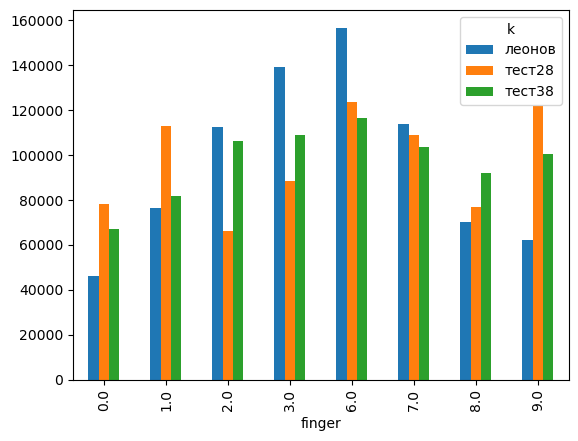

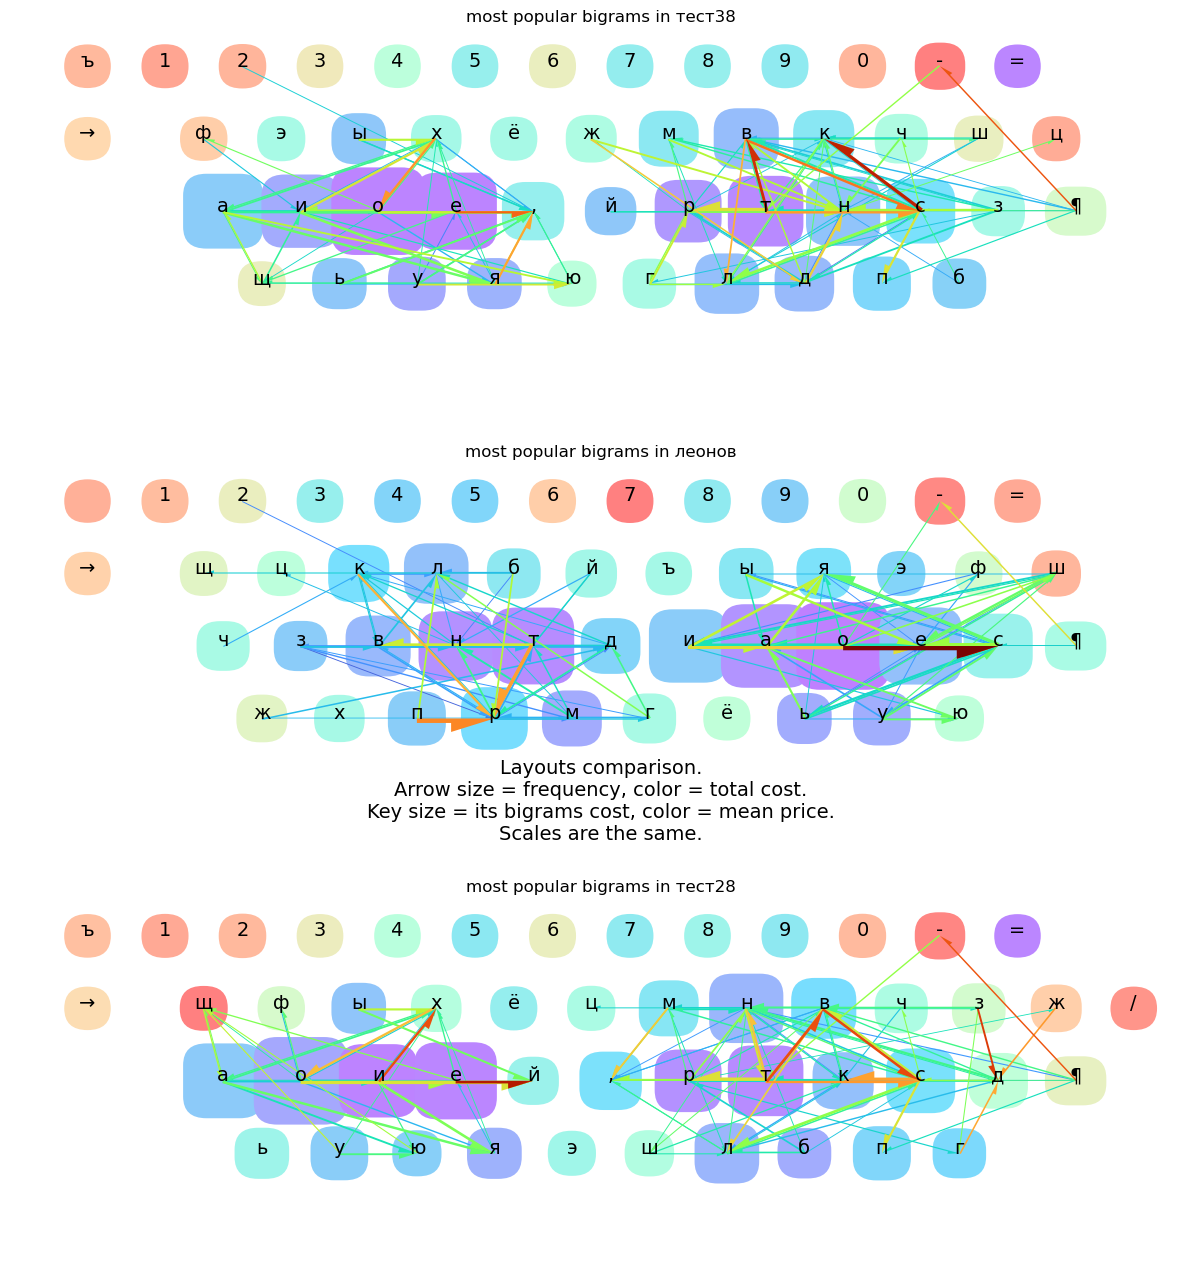

In [61]:
# →щфыхэ цзмквчш/
#  аиоей ,ртнсг¶
#  ьуюяё жлдпб

lyt = Layout('тест38', (r'''
ъ12345 67890-=
→фэыхё жмвкчшц
 аиое, йртнсз¶
 щьуяю глдпб
⌴

\!"№;% :?*()_+
∅∅∅∅∅∅ ∅∅∅∅∅∅∅∅
 ∅∅∅∅. ∅∅∅∅∅∅∅
 ∅∅∅∅∅ ∅∅∅∅∅
∅
''', real_kbd))


results[lyt.name] = r = Result(CORP, lyt)
print(lyt.name, ':', round(r.score, 3), '')

dfs = []
for k in ('тест28', 'тест38', 'леонов'):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d['k'] = k
    dfs.append(d)
pd.concat(dfs).pivot_table('num', 'k', 'finger').T.plot.bar()

results['тест38'].combomap(results['леонов'], results['тест28'])


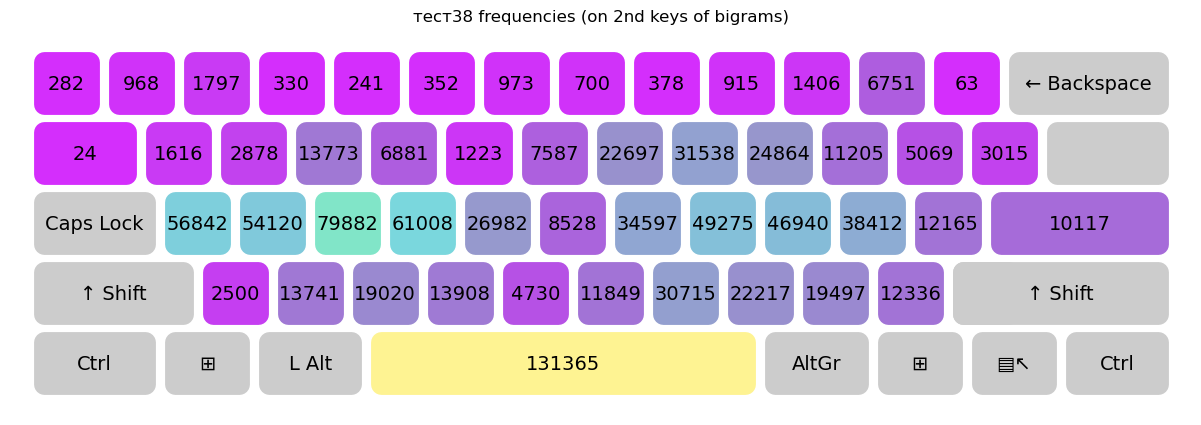

In [62]:
results['тест38'].display('num')

In [63]:
results['тест38'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "v37" {
		include "ru(common)"
		name[Group1]= "Culebron (тест38)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_e, Cyrillic_E ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_zhe, Cyrillic_ZHE ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyrillic_

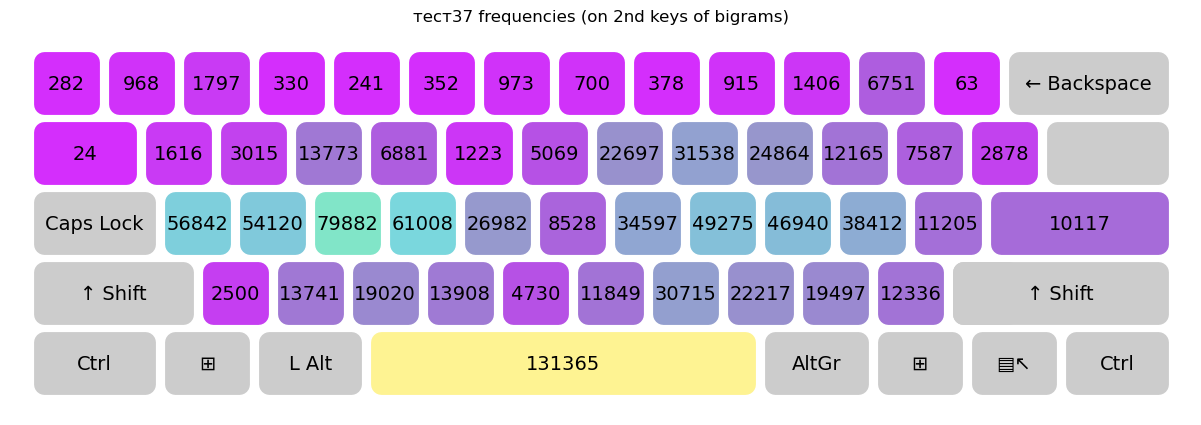

In [16]:
results['тест37'].display('num')

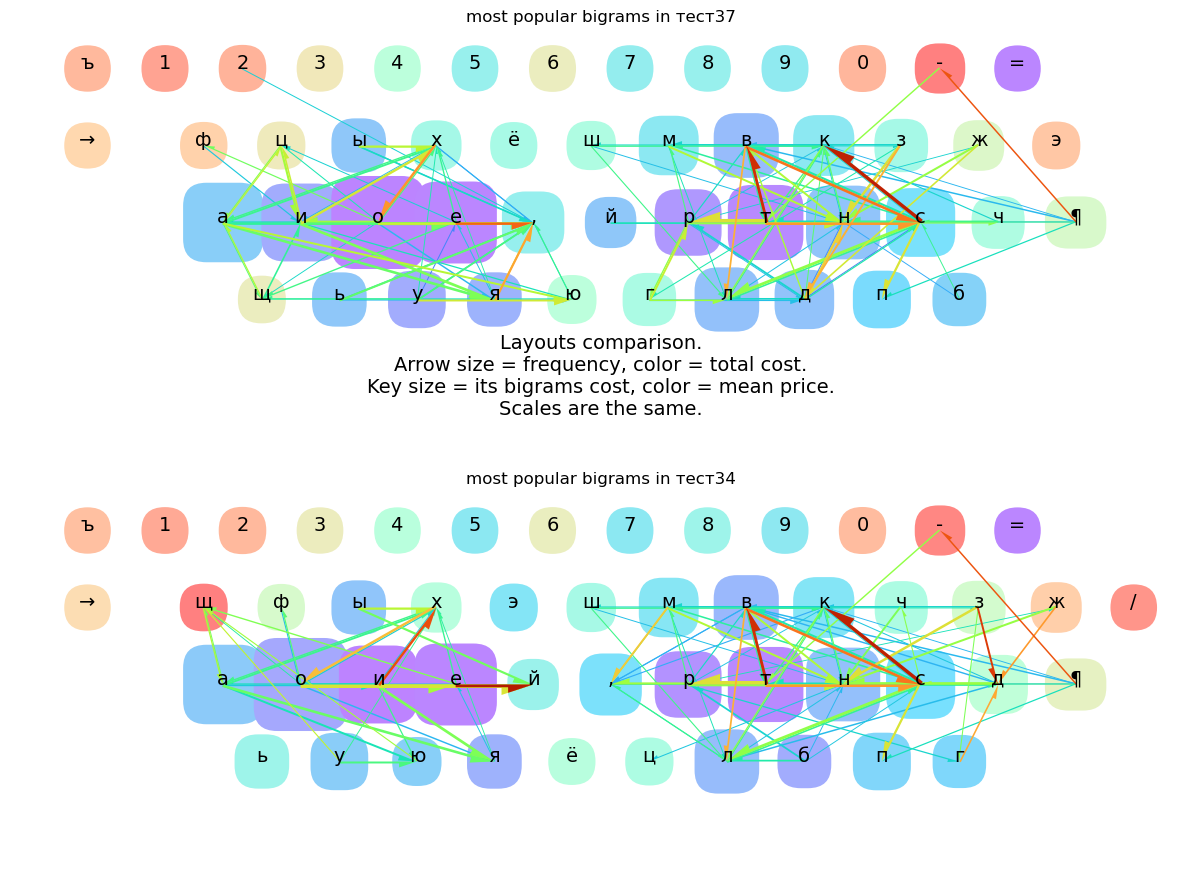

In [17]:
results['тест37'].combomap(results['тест34'])

In [18]:
results['тест34'].compare(results['тест37']).sort_values('delta', ascending=False).head(30)

bigram   num                     category_old  price_old  cost_old  \
182     ⌴э  2440                        space bar          3      7320   
23      ⌴и  9284                        space bar          0         0   
272     е,  1459                     altern hands          2      2918   
15      ни  7156                     altern hands          0         0   
132     я,  1162                     altern hands          2      2324   
153     ог  3341                     altern hands          2      6682   
79      ⌴г  3298                        space bar          2      6596   
7       ли  5507                     altern hands          0         0   
365     е.   905                     altern hands          2      1810   
225     ⌴б  4888                        space bar          1      4888   
350     я.   806                     altern hands          2      1612   
259     гр   958       in, over 1 finger, adj row          1       958   
231     ци  1184                     altern hands          0         0   
28      ри  4244                     altern hands          0         0   
289     ац   399                     altern hands          4      1596   
332     ег  1977                     altern hands          2      3954   
33      ти  3904                     altern hands          0         0   
491     гл   645      in, over 1 finger, same row          1       645   
184     ое  1887      in, over 1 finger, same row          0         0   
412     дв   536       in, over 1 finger, adj row          2      1072   
298     ца   345                     altern hands          2       690   
247     иц   647                     altern hands          4      2588   
187     об  3213                     altern hands          1      3213   
162     аю  1053       in, over 1 finger, adj row          2      2106   
378     ую  1019  in, adj finger, same or adj row          3      3057   
164     о,  1483                     altern hands          2      2966   
411     дн  1467  in, adj finger, same or adj row          3      4401   
110     ки  2886                     altern hands          0         0   
229     лю   960                     altern hands          1       960   
257     ои   917  in, adj finger, same or adj row          2      1834   

                        category_new  price_new  cost_new  delta  
182                        space bar          8     19520  12200  
23                         space bar          1      9284   9284  
272              same finger adj row          8     11672   8754  
15                      altern hands          1      7156   7156  
132              same finger adj row          8      9296   6972  
153                     altern hands          4     13364   6682  
79                         space bar          4     13192   6596  
7                       altern hands          1      5507   5507  
365              same finger adj row          8      7240   5430  
225                        space bar          2      9776   4888  
350              same finger adj row          8      6448   4836  
259              same finger adj row          6      5748   4790  
231          pinky -> ring, next row          4      4736   4736  
28                      altern hands          1      4244   4244  
289                    pinky adj row         14      5586   3990  
332                     altern hands          4      7908   3954  
33                      altern hands          1      3904   3904  
491              same finger adj row          7      4515   3870  
184  in, adj finger, same or adj row          2      3774   3774  
412             same finger over row          9      4824   3752  
298                    pinky adj row         12      4140   3450  
247          ring -> pinky, next row          9      5823   3235  
187                     altern hands          2      6426   3213  
162       in, over 1 finger, adj row          5      5265   3159  
378  in, adj finger, same or adj r

## Compare with others <a name="compare">

See what has changed, what bigrams degraded, and what were benefitial.

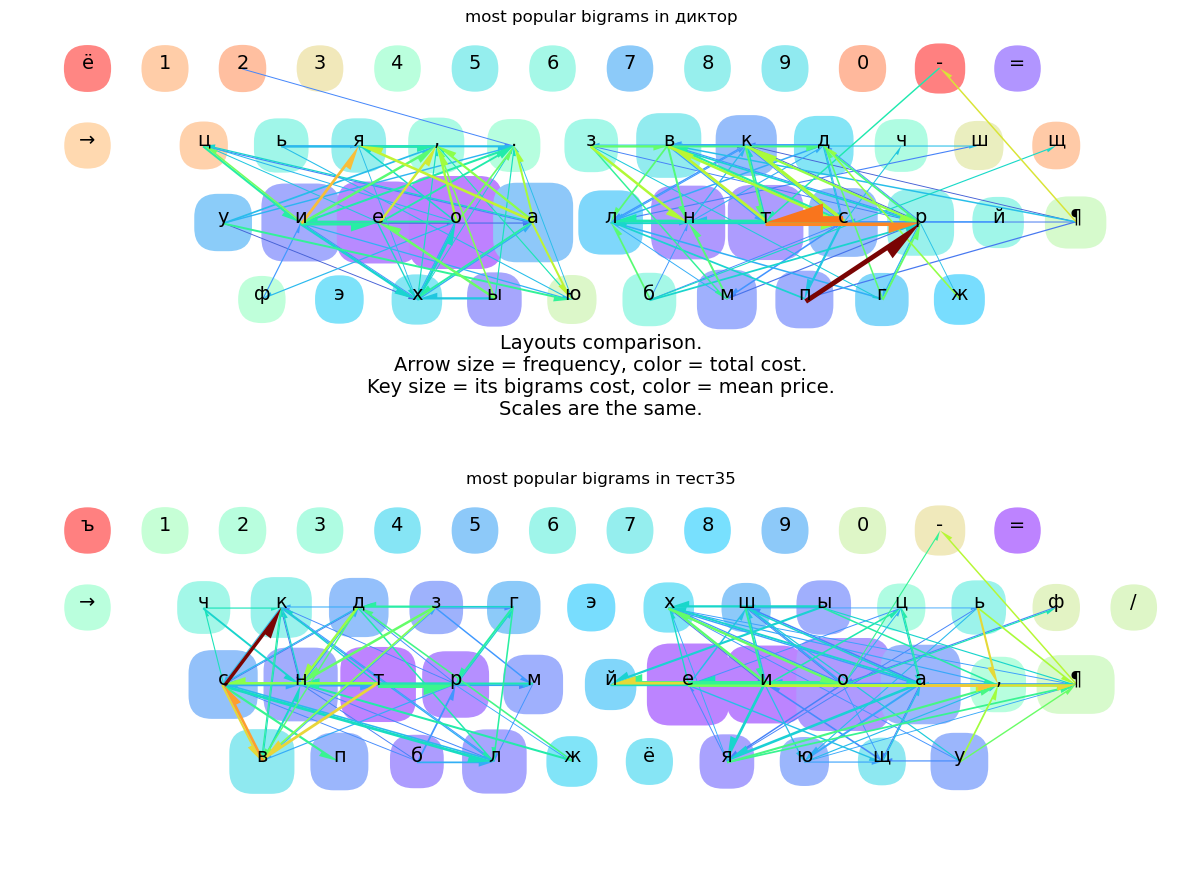

In [19]:
results['диктор'].combomap(results['тест35'])

## Losses

In [20]:
compare(results, 'тест32', 'тест33').head(30)

bigram   num                     category_old  price_old  cost_old  \
25      ⌴м  5232                        space bar          1      5232   
191     ом  4114                     altern hands          1      4114   
133     ⌴ч  3827                        space bar          4     15308   
102     ем  3307                     altern hands          1      3307   
41      пр  6010                     altern hands          0         0   
106     им  2603                     altern hands          1      2603   
299     ам  2406                     altern hands          1      2406   
916     ща   415                     altern hands          2       830   
192     м,   964  in, adj finger, same or adj row          4      3856   
394     ош   728                     altern hands          3      2184   
111     их  1574             out, over one finger          6      9444   
452     аш   627                     altern hands          3      1881   
209     еш   584                     altern hands          3      1752   
430     ьш   576                     altern hands          3      1728   
219     ич  1408                     altern hands          4      5632   
331     ущ   350                     altern hands          8      2800   
100     оч  1349                     altern hands          4      5396   
973     оф   373                    in, lower row          2       746   
284     ⌴ш   460                        space bar          3      1380   
217     иш   440                     altern hands          3      1320   
207     уч  1082                     altern hands          4      4328   
424     м.   538  in, adj finger, same or adj row          4      2152   
521     вш   295  in, adj finger, same or adj row          5      1475   
435     ию   408                    in, lower row          2       816   
378     ую  1019      in, over 1 finger, same row          1      1019   
379     ющ   332                     altern hands          8      2656   
239     ым   975                     altern hands          1       975   
451     уш   384                     altern hands          3      1152   
249     ач   946                     altern hands          4      3784   
792     ащ   235                     altern hands          8      1880   

                        category_new  price_new  cost_new  delta  
25                         space bar          3     15696  10464  
191                     altern hands          3     12342   8228  
133                        space bar          6     22962   7654  
102                     altern hands          3      9921   6614  
41        in, over 1 finger, adj row          1      6010   6010  
106                     altern hands          3      7809   5206  
299                     altern hands          3      7218   4812  
916                    pinky adj row         12      4980   4150  
192              same finger adj row          8      7712   3856  
394                     altern hands          8      5824   3640  
111              same finger adj row          8     12592   3148  
452                     altern hands          8      5016   3135  
209                     altern hands          8      4672   2920  
430                     altern hands          8      4608   2880  
219                     altern hands          6      8448   2816  
331              adj finger over row         16      5600   2800  
100                     altern hands          6      8094   2698  
973          ring -> pinky, next row          9      3357   2611  
284                        space bar          8      3680   2300  
217                     altern hands          8      3520   2200  
207                     altern hands          6      6492   2164  
424              same finger adj row          8      4304   2152  
521             out, over one finger         12      3540   2065  
435              same finger adj row          7      2856   2040  
378  in, adj finger, same or adj r

## Gains

In [21]:
compare(results, 'тест32', 'тест33').tail(30)

bigram    num               category_old  price_old  cost_old  \
274     ах    942    pinky -> ring, next row          5      4710   
157     ты   1128               altern hands          4      4512   
422     еп    602             index -> pinky          6      3612   
182     ⌴э   2440                  space bar          4      9760   
472     оз   1229               altern hands          6      7374   
417     ез   1314               altern hands          6      7884   
70      ры   1324               altern hands          4      5296   
131     ся   3016               altern hands          2      6032   
445     пы    219             pinky over row         16      3504   
276     сь   1534               altern hands          6      9204   
187     об   3213               altern hands          2      6426   
194     хо   1638        same finger adj row          7     11466   
498     зм    567  over 1 finger, over 1 row          9      5103   
188     бщ    337        adj finger over row         18      6066   
112     вы   2043               altern hands          4      8172   
159     уп    711       out, over one finger          8      5688   
64      из   2251               altern hands          6     13506   
205     бы   2274               altern hands          4      9096   
225     ⌴б   4888                  space bar          2      9776   
116     аз   2695               altern hands          6     16170   
94      ⌴з   3466                  space bar          6     20796   
236     ны   3979               altern hands          4     15916   
295     оп   1156    ring -> pinky, next row          9     10404   
46      ль   4283               altern hands          6     25698   
291     ап    735              pinky adj row         14     10290   
38      ть   5581               altern hands          6     33486   
303     па   1120              pinky adj row         12     13440   
262     ия   1949        same finger adj row          8     15592   
55      по   7093    pinky -> ring, next row          4     28372   
40      ⌴п  13192                  space bar          4     52768   

                    category_new  price_new  cost_new  delta  
274   in, over 1 finger, adj row          3      2826  -1884  
157                 altern hands          2      2256  -2256  
422                 altern hands          2      1204  -2408  
182                    space bar          3      7320  -2440  
472                 altern hands          4      4916  -2458  
417                 altern hands          4      5256  -2628  
70                  altern hands          2      2648  -2648  
131                 altern hands          1      3016  -3016  
445                 altern hands          2       438  -3066  
276                 altern hands          4      6136  -3068  
187                 altern hands          1      3213  -3213  
194         out, over one finger          5      8190  -3276  
498  in, over 1 finger, same row          3      1701  -3402  
188                 altern hands          6      2022  -4044  
112                 altern hands          2      4086  -4086  
159                 altern hands          2      1422  -4266  
64                  altern hands          4      9004  -4502  
205                 altern hands          2      4548  -4548  
225                    space bar          1      4888  -4888  
116                 altern hands          4     10780  -5390  
94                     space bar          4     13864  -6932  
236                 altern hands          2      7958  -7958  
295                 altern hands          2      2312  -8092  
46                  altern hands          4     17132  -8566  
291                 altern hands          2      1470  -8820  
38                  altern hands          4     22324 -11162  
303                 altern hands          2      2240 -11200  
262                in, lower row          2      3898 -11694  
55                  altern hands     

You can save the comparison table to CSV:

In [22]:
compare(results, 'леонов', 'тест33').to_csv('leonov-test33.csv')

## Simple Statistics, What Cost The Most <a name="simple-stats">

In [23]:
results['тест33'].bigrams.sort_values('cost', ascending=False).head(30) #.to_csv('/tmp/test26.csv')

bigram    num l1 l2 t1 t2      freq  price_l2  price_di  \
177     .¶   3921  .  ¶  -  -  0.004300         6         2   
53      ¶¶   4802  ¶  ¶  -  -  0.005266         6         0   
40      ⌴п  13192  ⌴  п  -  c  0.014466         2         0   
127     ⌴с  11948  ⌴  с  -  c  0.013102         2         0   
227     ⌴д   5792  ⌴  д  -  c  0.006351         4         0   
133     ⌴ч   3827  ⌴  ч  -  c  0.004197         6         0   
38      ть   5581  т  ь  c  v  0.006120         4         0   
124     ⌴-   2268  ⌴  -  -  -  0.002487         9         0   
195     од   4816  о  д  v  c  0.005281         4         0   
125     --   2097  -  -  -  -  0.002300         9         0   
46      ль   4283  л  ь  c  v  0.004697         4         0   
296     ей   2009  е  й  v  c  0.002203         2         6   
105     на   8003  н  а  c  v  0.008776         2         0   
25      ⌴м   5232  ⌴  м  -  c  0.005737         3         0   
114     ск   3125  с  к  c  c  0.003427         2         3   
10      ра   7597  р  а  c  v  0.008331         2         0   
49      тв   2081  т  в  c  c  0.002282         1         6   
94      ⌴з   3466  ⌴  з  -  c  0.003801         4         0   
447     зд    979  з  д  c  c  0.001074         4        10   
30      ⌴к   6687  ⌴  к  -  c  0.007333         2         0   
111     их   1574  и  х  v  c  0.001726         2         6   
191     ом   4114  о  м  v  c  0.004511         3         0   
802     ¶-    586  ¶  -  -  -  0.000643         9        12   
66      ⌴н  11829  ⌴  н  -  c  0.012971         1         0   
115     ка   5674  к  а  c  v  0.006222         2         0   
18      ⌴в  11347  ⌴  в  -  c  0.012443         1         0   
465     вс   1832  в  с  c  c  0.002009         2         4   
56      ос   5489  о  с  v  c  0.006019         2         0   
116     аз   2695  а  з  v  c  0.002955         4         0   
62      то  10353  т  о  c  v  0.011353         1         0   

                    category  price   cost  finger  column  row  
177           index -> pinky      8  31368     9.0    13.0  2.0  
53                  same key      6  28812     9.0    13.0  2.0  
40                 space bar      2  26384     8.0    10.0  3.0  
127                space bar      2  23896     9.0    11.0  2.0  
227                space bar      4  23168     9.0    12.0  2.0  
133                space bar      6  22962     9.0    12.0  1.0  
38              altern hands      4  22324     0.0     1.0  3.0  
124                space bar      9  20412     9.0    12.0  0.0  
195             altern hands      4  19264     9.0    12.0  2.0  
125                 same key      9  18873     9.0    12.0  0.0  
46              altern hands      4  17132     0.0     1.0  3.0  
296      same finger adj row      8  16072     3.0     5.0  2.0  
105             altern hands      2  16006     0.0     1.0  2.0  
25                 space bar      3  15696     6.0     8.0  1.0  
114  pinky -> ring, next row      5  15625     8.0    10.0  1.0  
10              altern hands      2  15194     0.0     1.0  2.0  
49       same finger adj row      7  14567     7.0     9.0  1.0  
94                 space bar      4  13864     9.0    11.0  1.0  
447            pinky adj row     14  13706     9.0    12.0  2.0  
30                 space bar      2  13374     8.0    10.0  1.0  
111      same finger adj row      8  12592     2.0     4.0  1.0  
191             altern hands      3  12342     6.0     8.0  1.0  
802           pinky over row     21  12306     9.0    12.0  0.0  
66                 space bar      1  11829     8.0    10.0  2.0  
115             altern hands      2  11348     0.0     1.0  2.0  
18                 space bar      1  11347     7.0     9.0  1.0  
465     out, over one finger      6  10992     9.0    11.0  2.0  
56              altern hands      2  10978     9.0    11.0  2.0  
116             altern hands      4  10780     9.0    11.0  1.0  
62              altern hands      1  10353     1.0     2.0  2.0

## Statistics of Bigrams to CSV <a name="output-statistics">

We count how often a key comes before or after which one. We add categories to simplify statistics analysis: vowel/consonant/other, hand (in layout 27), row, column. 

In [24]:
key = 'тест33' # the output file will be 'all-letters-melt-<key>.csv'
res = results[key]


BG = CORP.bigrams
km = res.layout.keymap
dg2 = BG[BG.l1.isin(BASE_KEYS_RU) & BG.l2.isin(BASE_KEYS_RU)].copy()
dg2['kind_after'] = dg2.t2
dg2['row1'] = dg2.l1.map(km['row'])
dg2['row2'] = dg2.l2.map(km['row'])
dg2['hand1'] = dg2.l1.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['hand2'] = dg2.l2.map(km['hand']).map({0: 'left', 1: 'right'})
dg2['dir'] = 'before'
dg2['kind_before'] = dg2.t1
dg2['letter_before'] = dg2.t1.isin(['v', 'c'])
dg2['hand'] = dg2.hand1
dg2['row'] = dg2.row1
dg2['letter_after'] = dg2.t2.isin(['v', 'c'])
pd1 = dg2.rename(columns={'l1': 'prev', 'l2': 'letter'}
        ).pivot_table('num', 'letter', ['dir', 'kind_before', 'hand', 'row', 'prev'], fill_value=0)

dg2['dir'] = 'after'
dg2['hand'] = dg2.hand2
dg2['row'] = dg2.row2

pd2 = dg2.rename(columns={'l2': 'next', 'l1': 'letter'}
                ).pivot_table('num', 'letter', ['dir', 'kind_after', 'hand', 'row', 'next'], fill_value=0)
dg3 = pd1.join(pd2) #.reset_index()

dg3.melt(ignore_index=False).reset_index().rename(
    columns={'variable_0': 'where', 'variable_1': 'ftype', 'variable_4': 'other', 
             'variable_2': 'hand', 'variable_3': 'row', 'value': 'num',
            'letter': 'letter'}).to_csv(f'all-letters-melt-{key}.csv')

## Check the keymap (for errors) <a name="keymap">

In [25]:
lyt.keymap
# or 
# results['тест28'][1]

layer  row  column  key_count  finger  ftype  hand  penalty
ъ      0    0       0          1       0      4     0        9
1      0    0       1          1       0      4     0        8
2      0    0       2          1       0      4     0        7
3      0    0       3          1       0      4     0        6
4      0    0       4          1       1      3     0        4
5      0    0       5          1       2      2     0        3
6      0    0       7          1       3      1     0        4
7      0    0       8          1       6      1     1        2
8      0    0       9          1       7      2     1        2
9      0    0      10          1       8      3     1        3
0      0    0      11          1       9      4     1        8
-      0    0      12          1       9      4     1        9
=      0    0      13          1       9      4     1        0
→      0    1       0          1       0      4     0        8
ф      0    1       1          1       0      4     0        6
ц      0    1       2          1       0      4     0        4
ы      0    1       3          1       1      3     0        2
х      0    1       4          1       2      2     0        2
ё      0    1       5          1       3      1     0        3
ш      0    1       7          1       6      1     1        4
м      0    1       8          1       6      1     1        3
в      0    1       9          1       7      2     1        1
к      0    1      10          1       8      3     1        2
з      0    1      11          1       9      4     1        4
ж      0    1      12          1       9      4     1        6
э      0    1      13          1       9      4     1        8
а      0    2       1          1       0      4     0        2
и      0    2       2          1       1      3     0        1
о      0    2       3          1       2      2     0        0
е      0    2       4          1       3      1     0        0
,      0    2       5          1       3      1     0        2
й      0    2       7          1       6      1     1        2
р      0    2       8          1       6      1     1        0
т      0    2       9          1       7      2     1        0
н      0    2      10          1       8      3     1        1
с      0    2      11          1       9      4     1        2
ч      0    2      12          1       9      4     1        4
¶      0    2      13          1       9      4     1        6
щ      0    3       1          1       0      4     0        4
ь      0    3       2          1       1      3     0        2
у      0    3       3          1       2      2     0        1
я      0    3       4          1       3      1     0        1
ю      0    3       5          1       3      1     0        4
г      0    3       7          1       6      1     1        4
л      0    3       8          1       6      1     1        1
д      0    3       9          1       7      2     1        1
п      0    3      10          1       8      3     1        2
б      0    3      11          1       9      4     1        2
⌴      0    4       0          1       4      0     0        0
\      1    0       0          1       0      4     0        9
!      1    0       1          1       0      4     0        8
"      1    0       2          1       0      4     0        7
№      1    0       3          1       0      4     0        6
;      1    0       4          1       1      3     0        4
%      1    0       5          1       2      2     0        3
:      1    0       7          1       3      1     0        4
?      1    0       8          1       6      1     1        2
*      1    0       9          1       7      2     1        2
(      1    0      10          1       8      3     1        3
)      1    0      11          1       9      4     1        8
_      1    0      12          1       9      4     1        9
+      1    0      13          1       9      4     1        0
.      1    2       5          1  

# Arrow Maps

All Russian layouts vs ЙЦУКЕН. Skoropis is essentially Diktor, and is omitted.

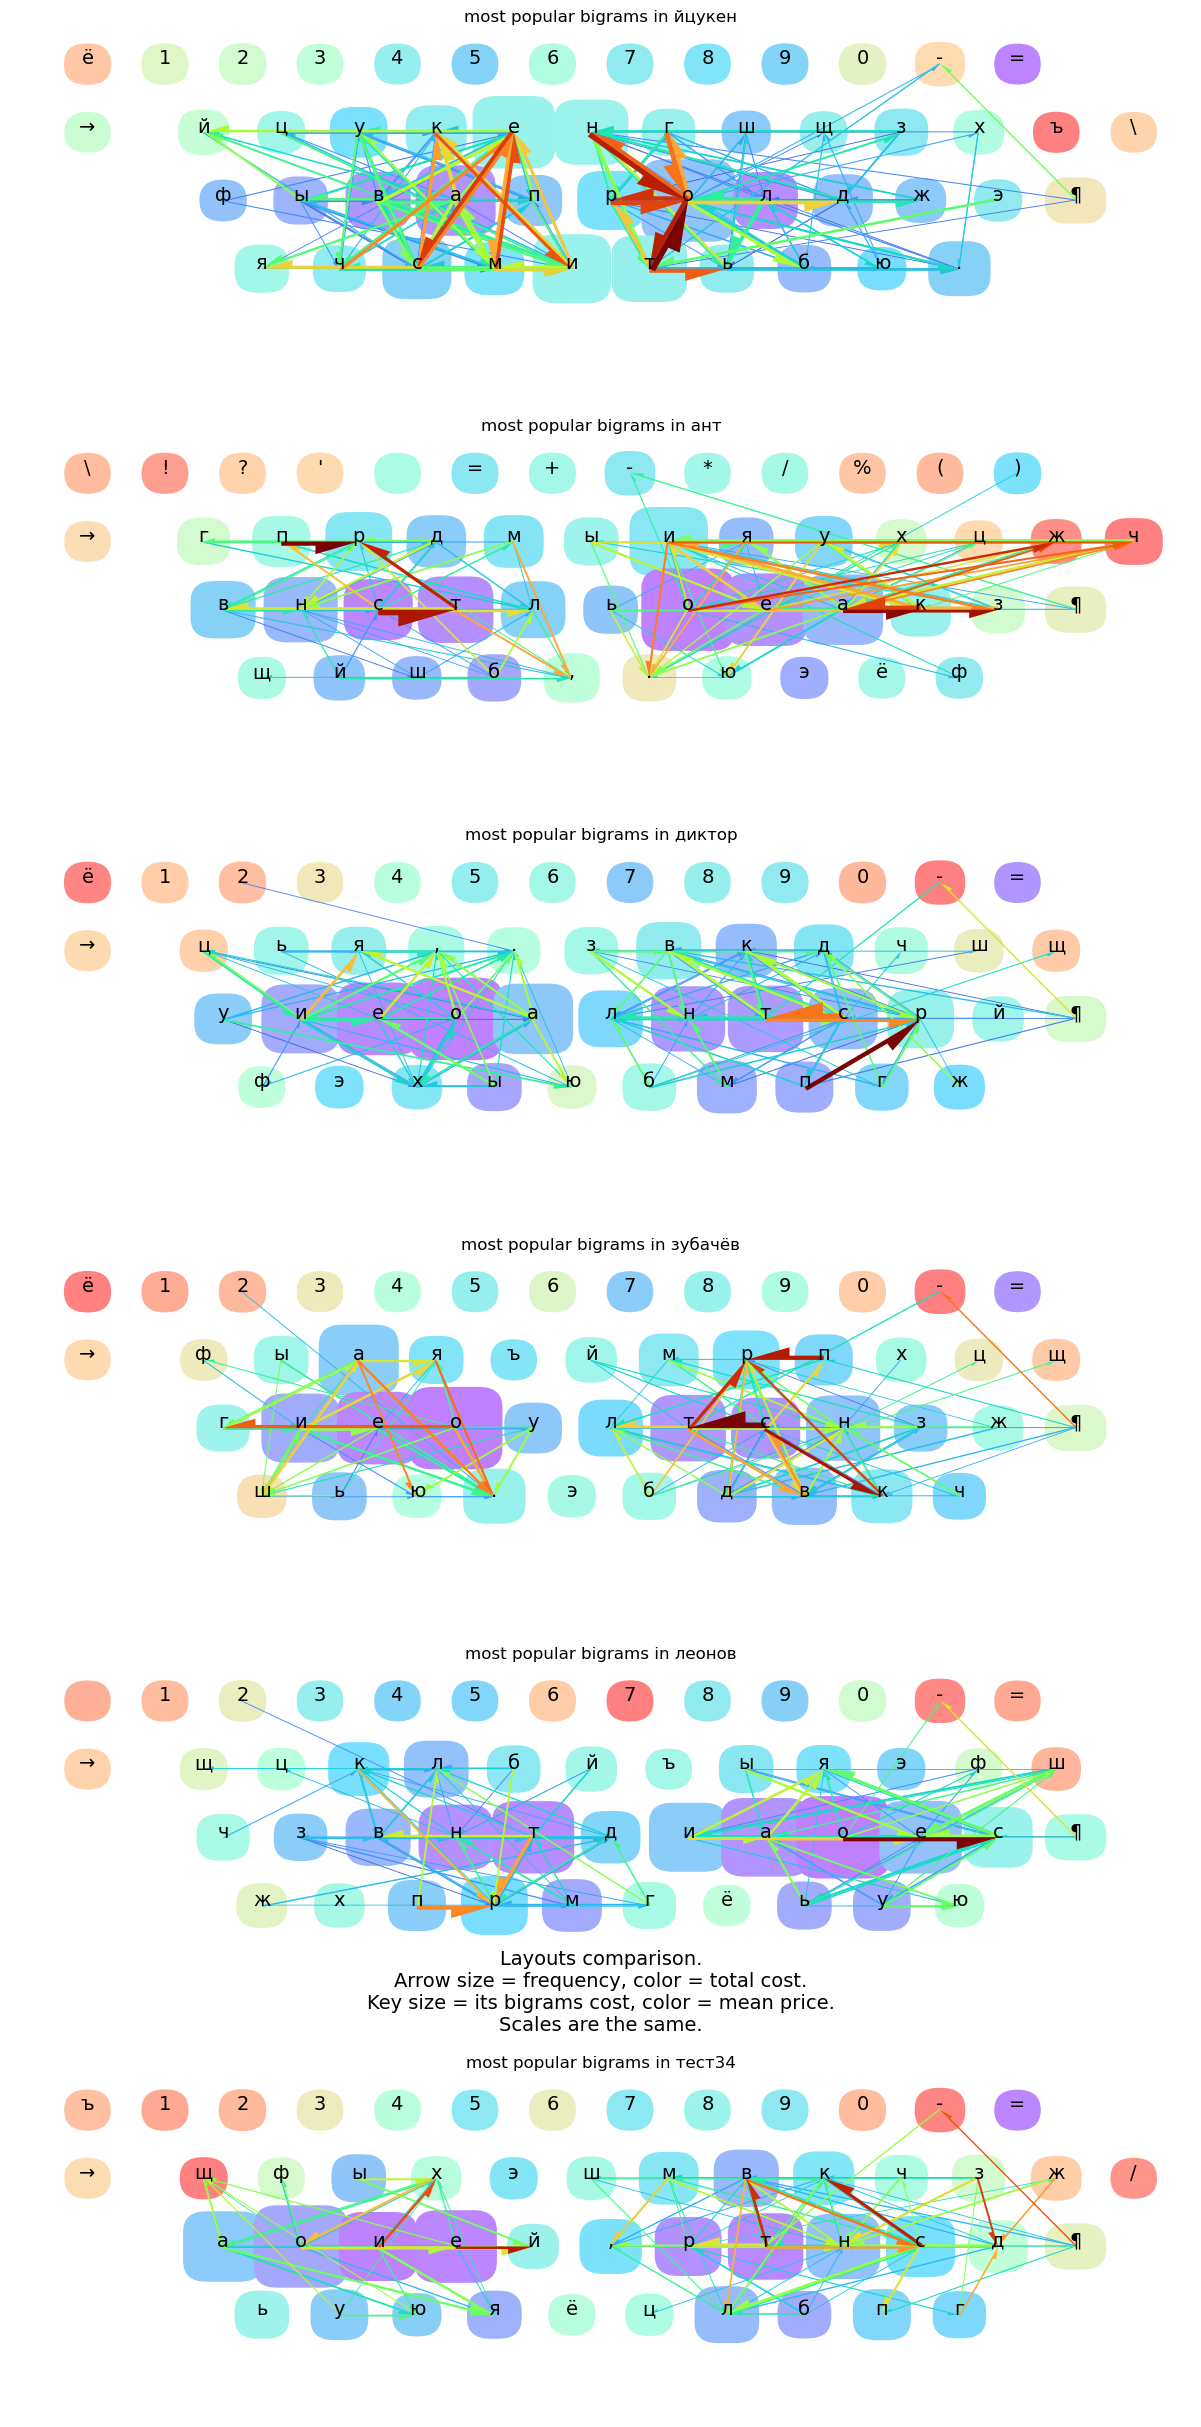

In [26]:
r = results
r['йцукен'].combomap(r['ант'], r['диктор'], r['зубачёв'], r['леонов'], r['тест34'])

# Heatmaps <a name="heatmaps">

To see the heatmap by just number of key presses, use `pivot_table('num'`, to see the one for penalties, use `pivot_table('cost'`.

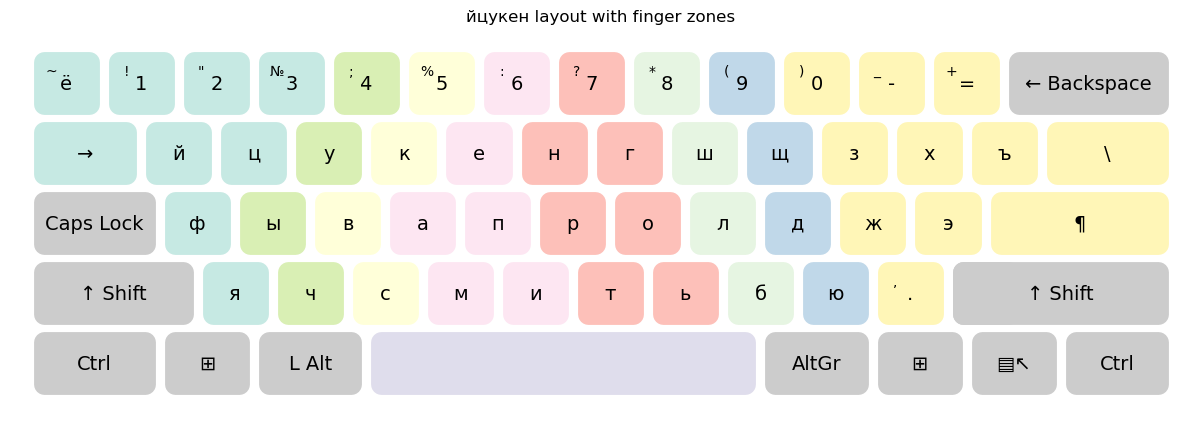

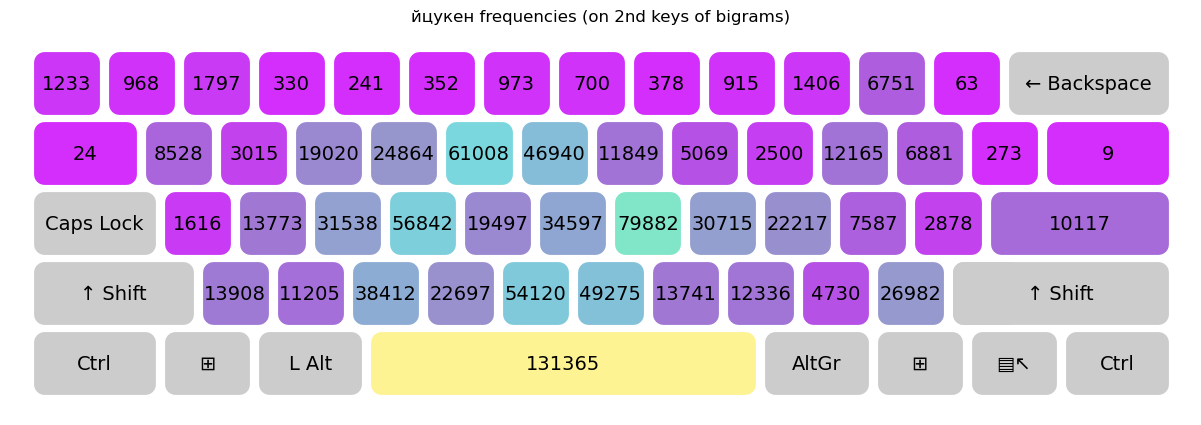

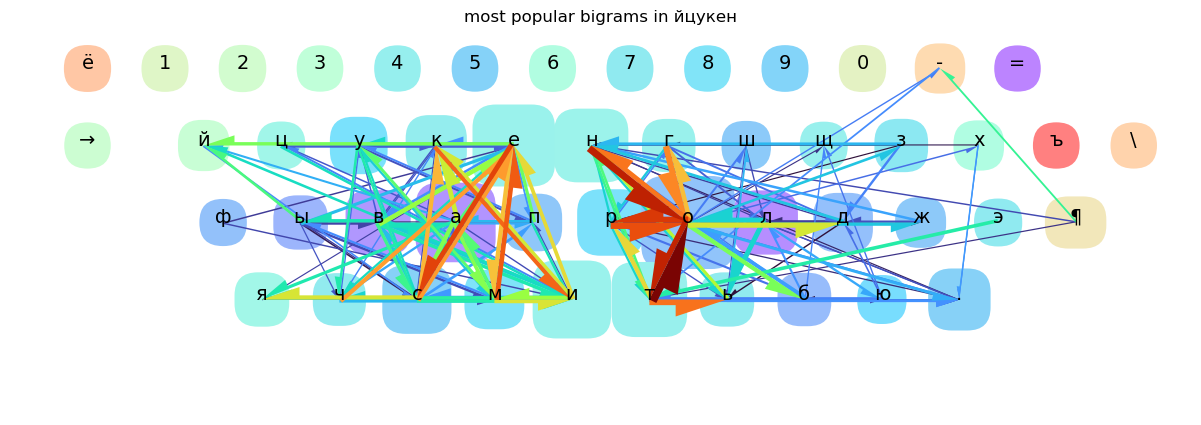

In [27]:
results['йцукен'].display('layout', 'num', 'arrows')

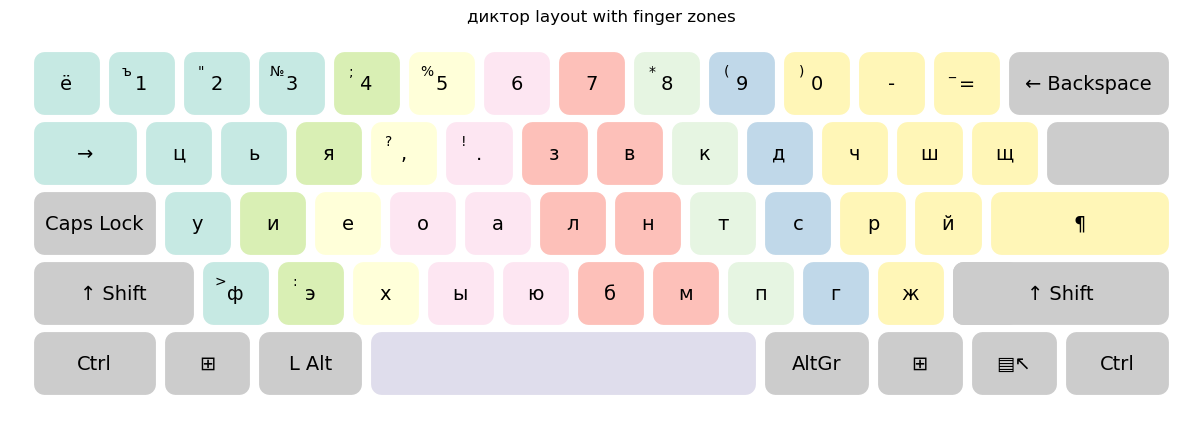

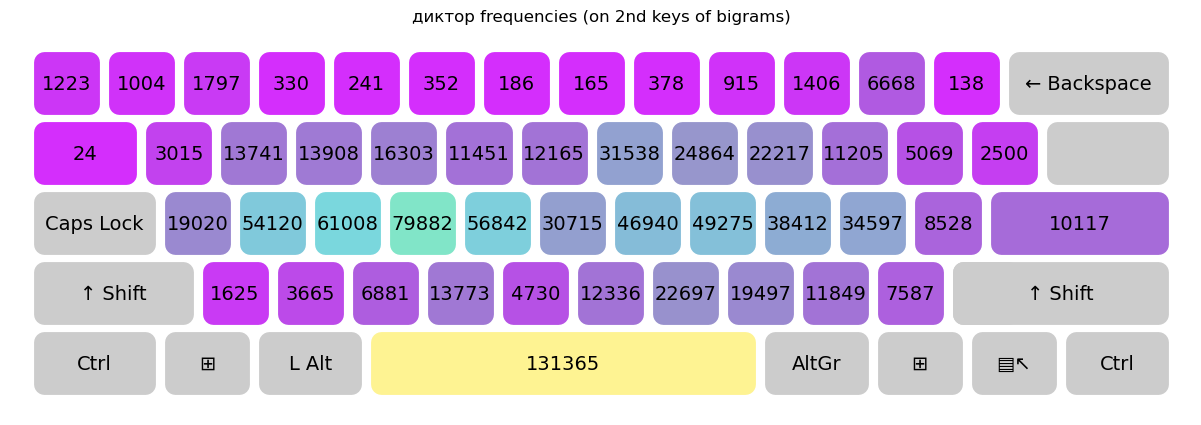

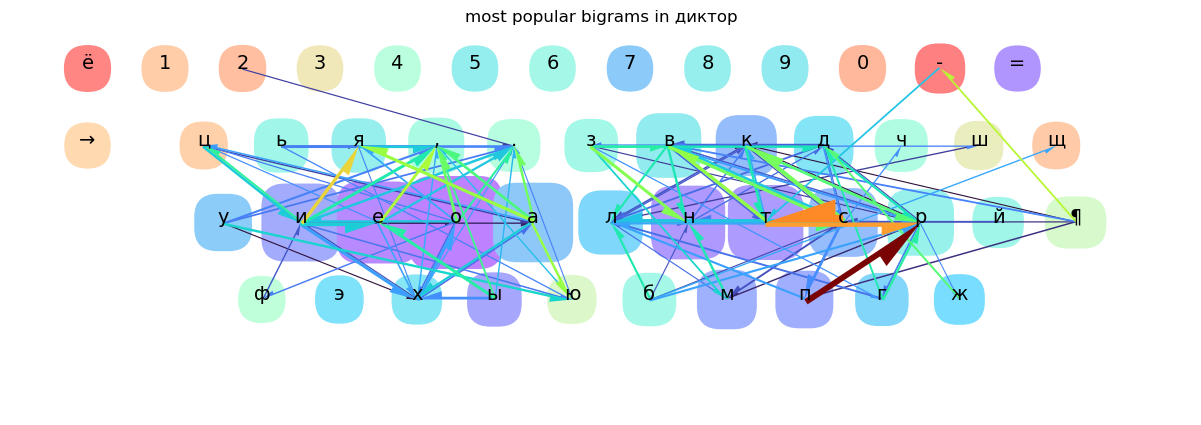

In [28]:
results['диктор'].display('layout', 'num', 'arrows')

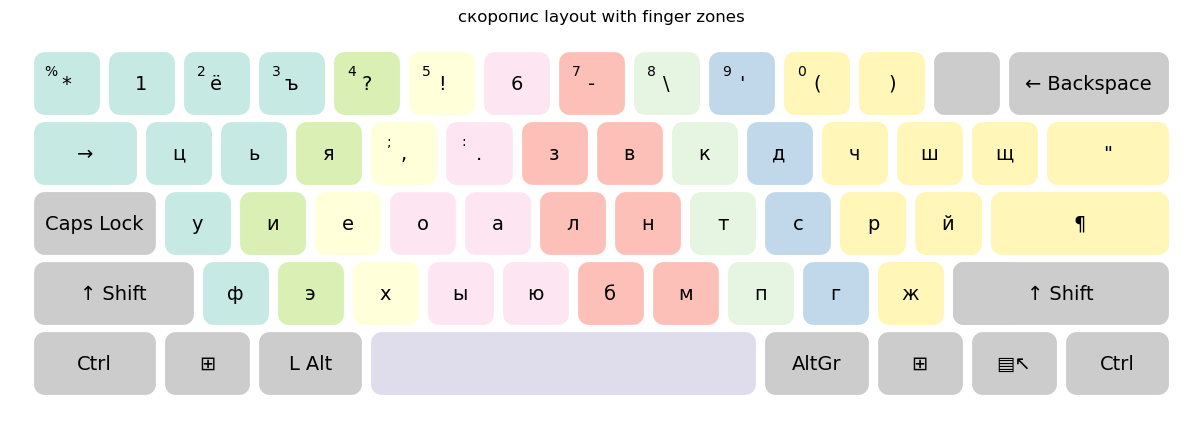

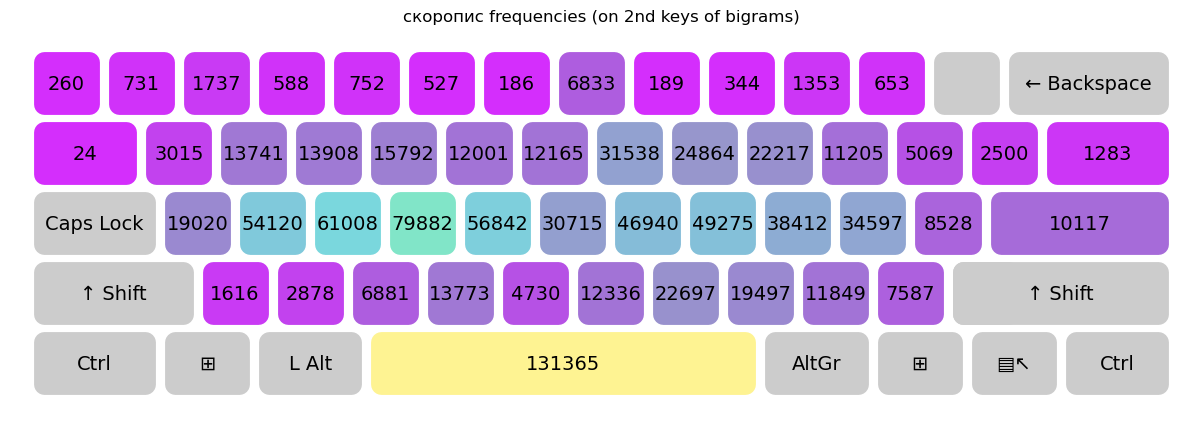

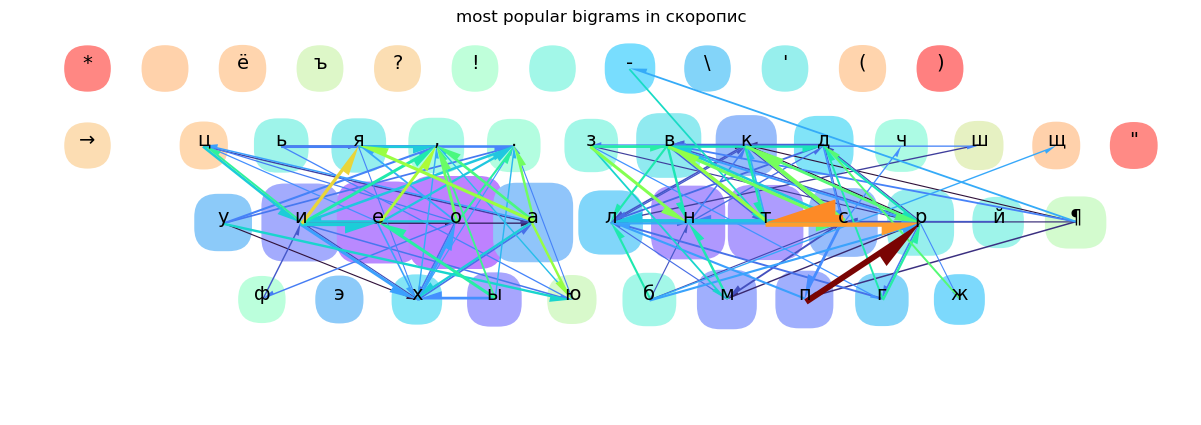

In [29]:
results['скоропис'].display('layout', 'num', 'arrows')

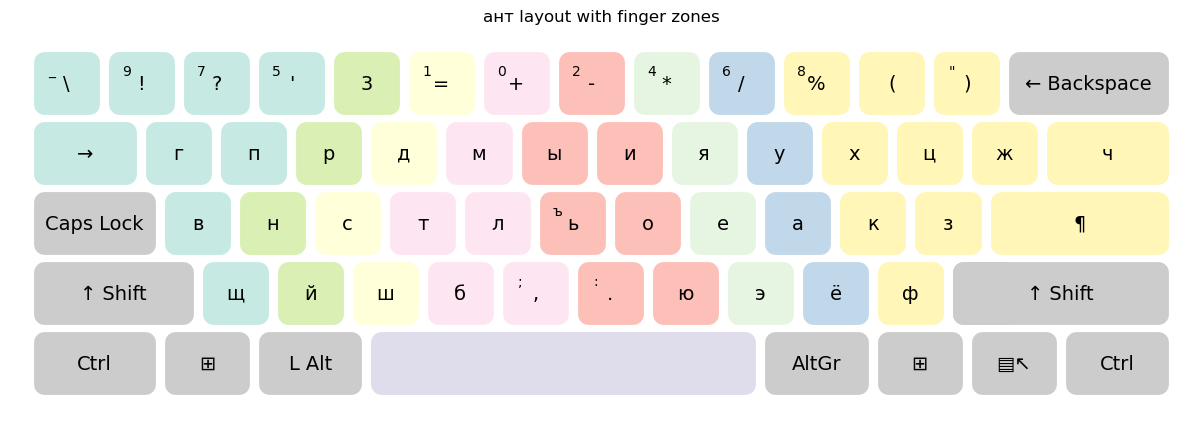

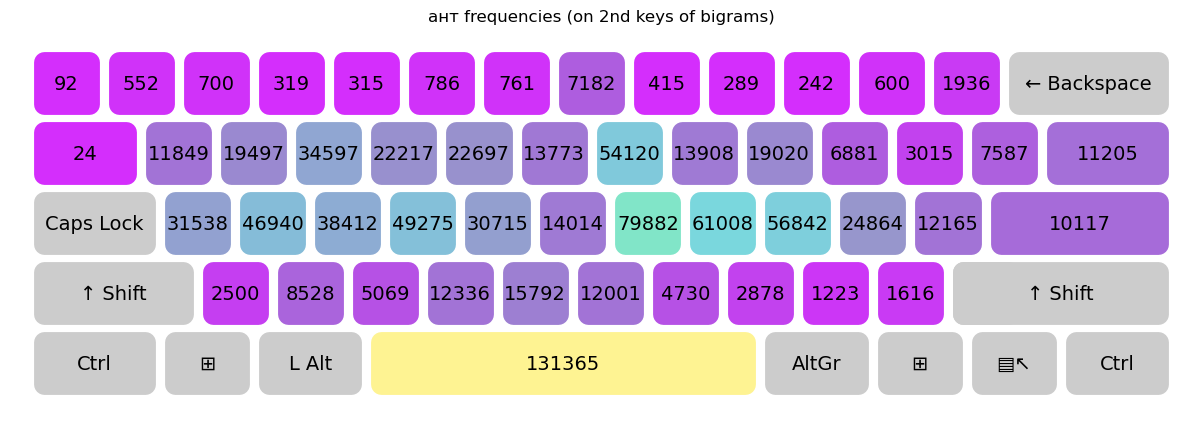

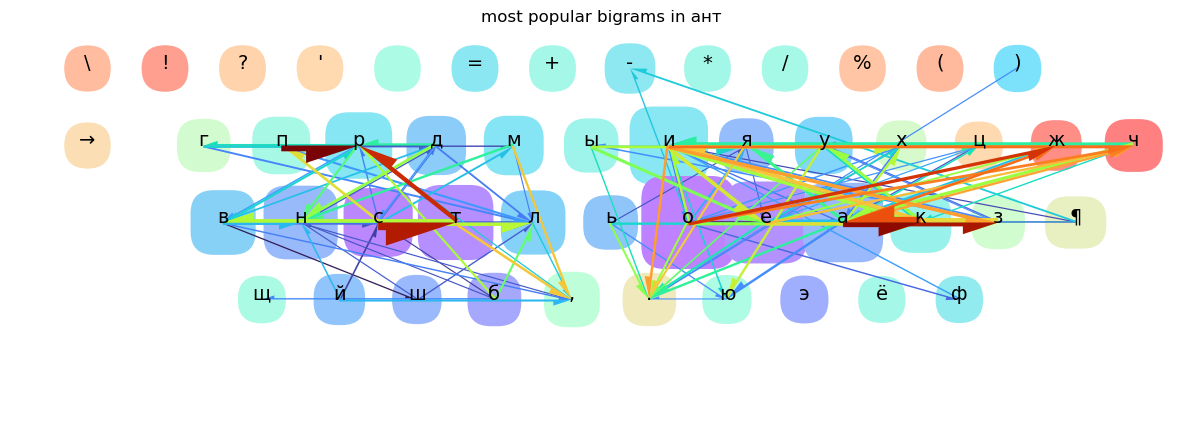

In [30]:
results['ант'].display('layout', 'num', 'arrows')

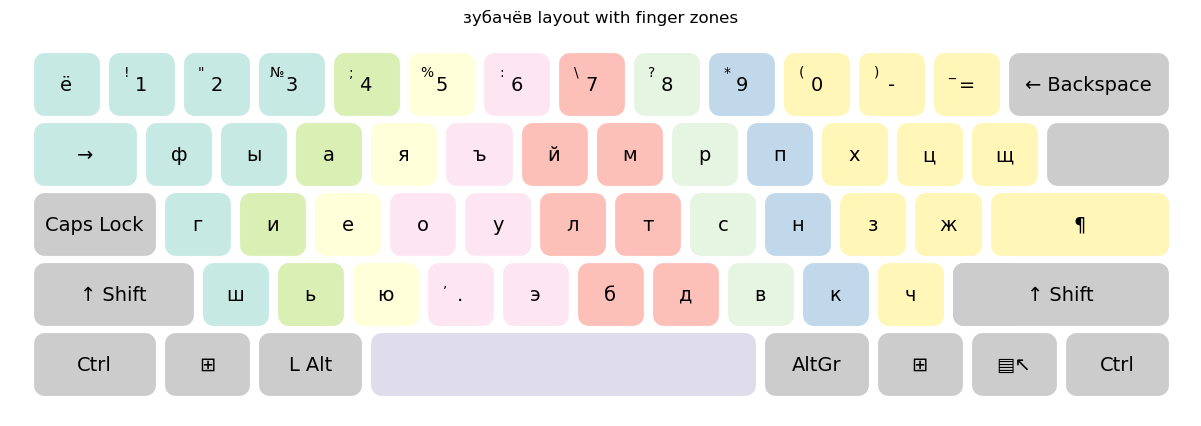

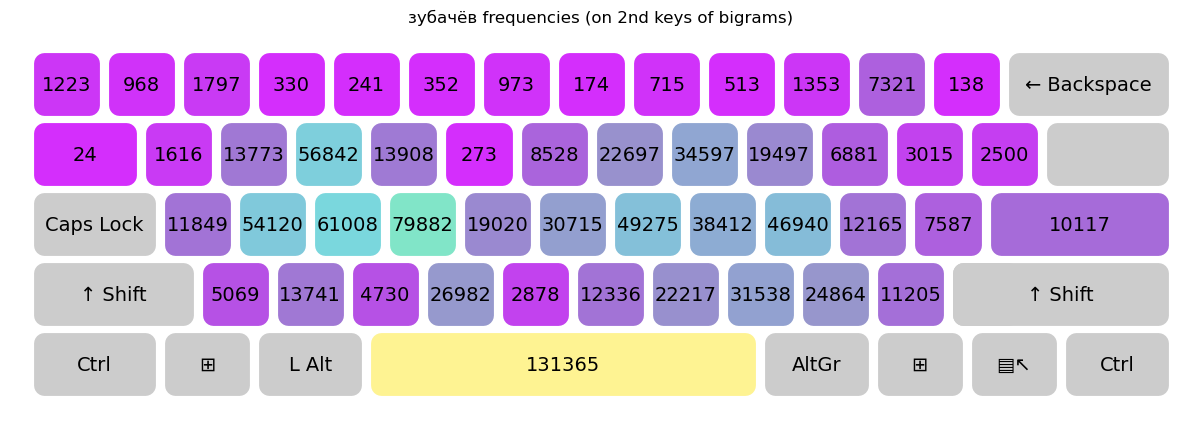

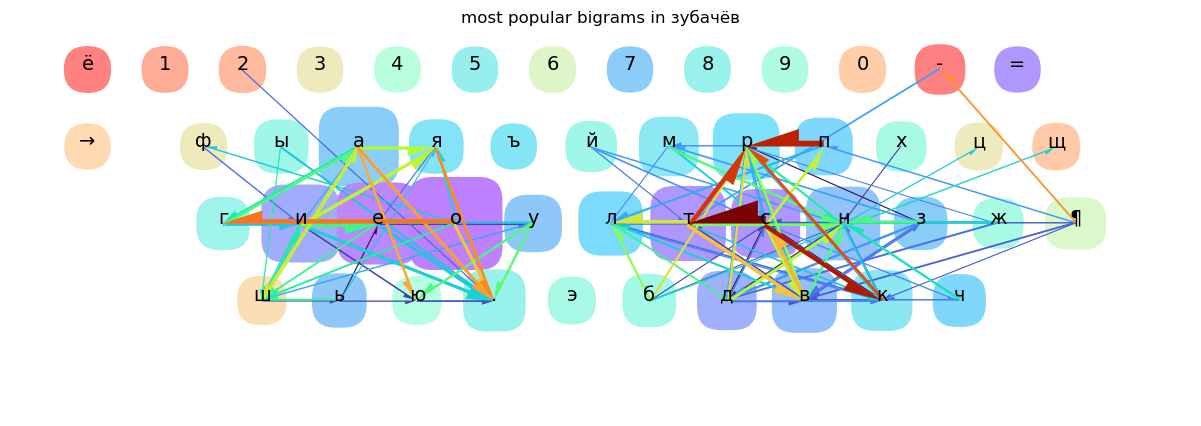

In [31]:
results['зубачёв'].display('layout', 'num', 'arrows')

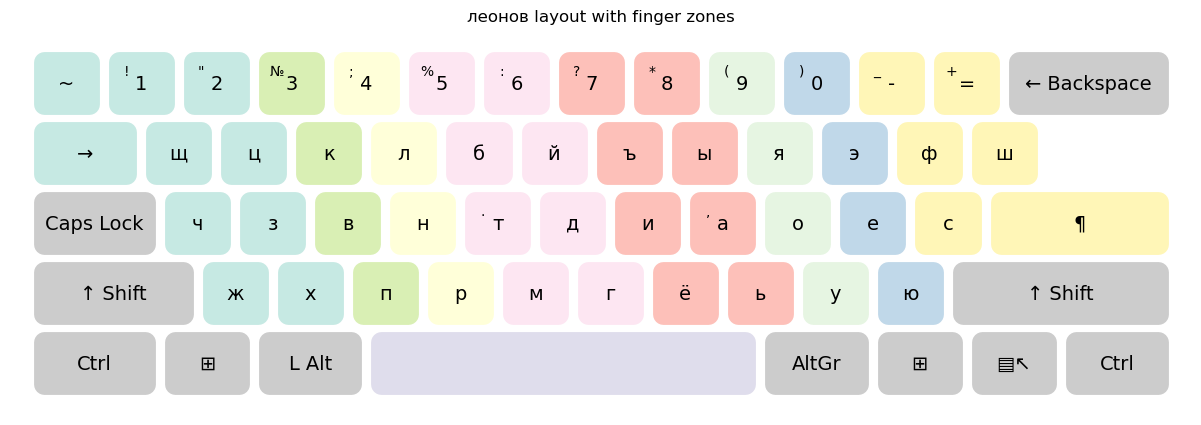

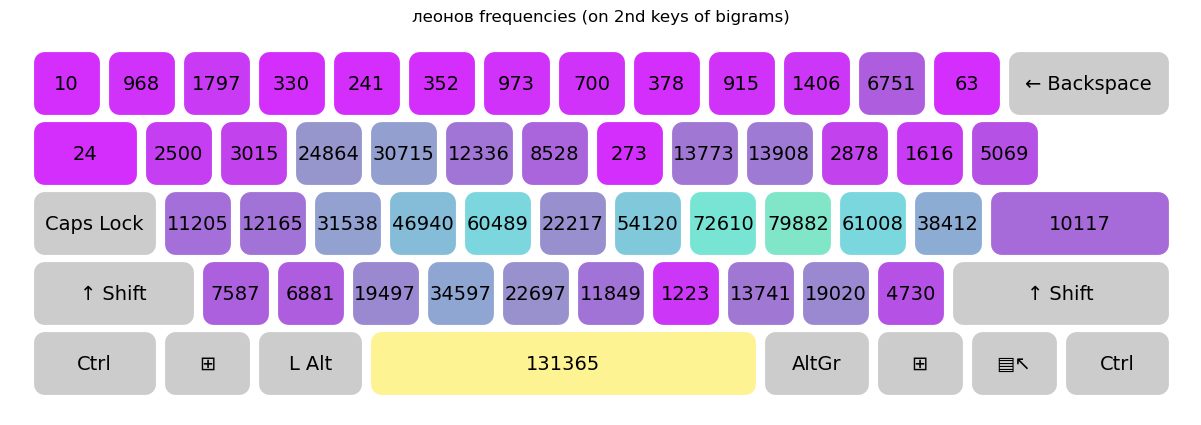

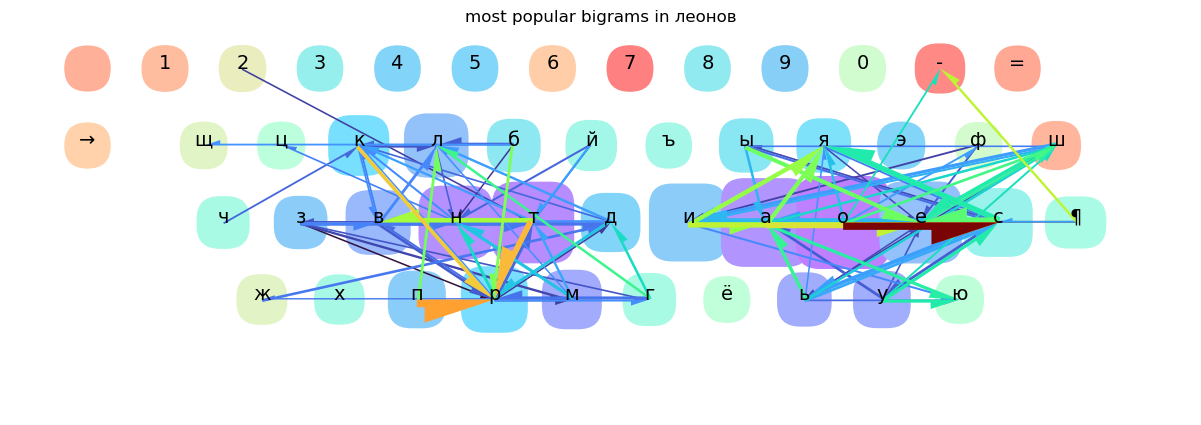

In [32]:
results['леонов'].display('layout', 'num', 'arrows')

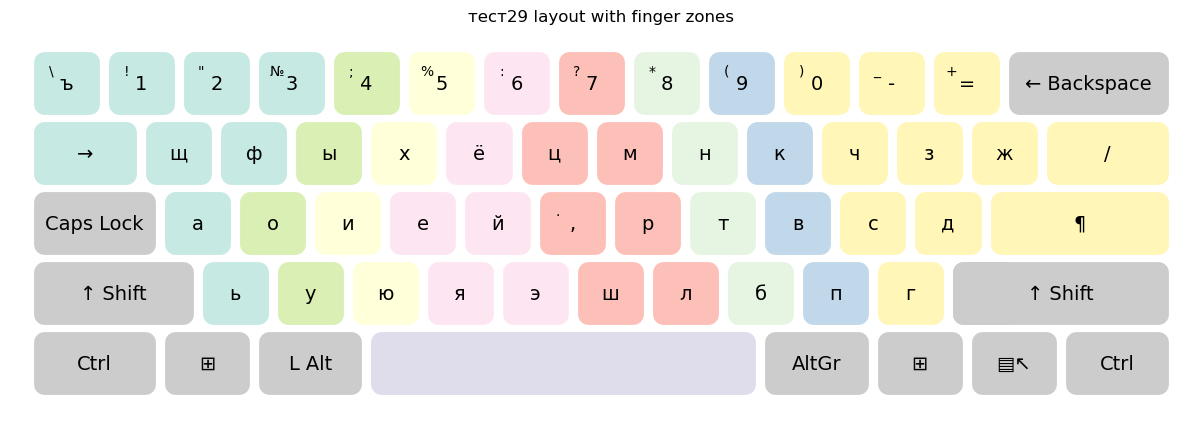

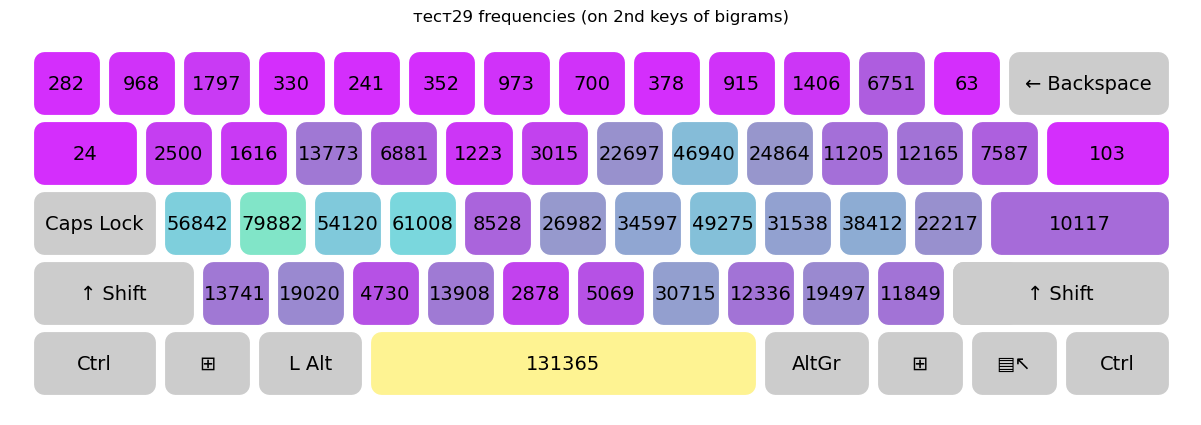

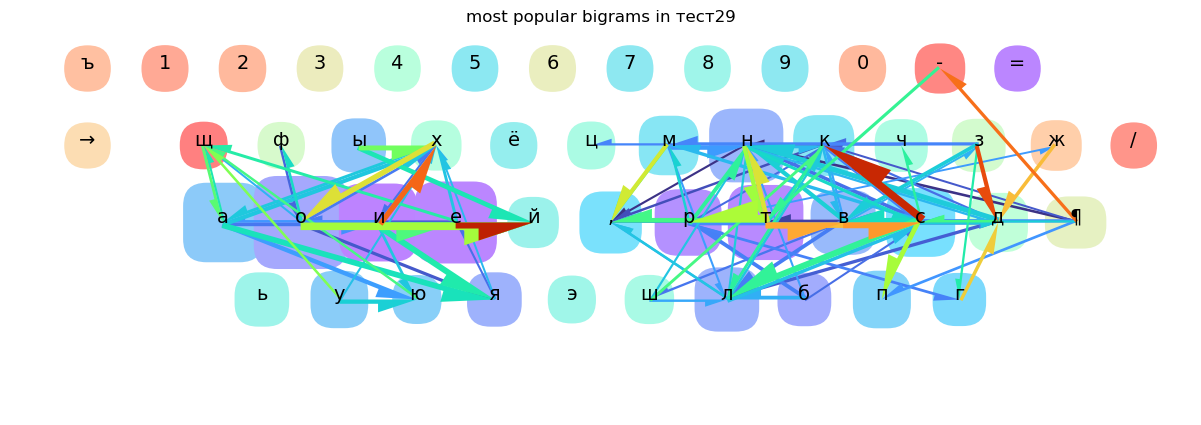

In [33]:
results['тест29'].display('layout', 'num', 'arrows')

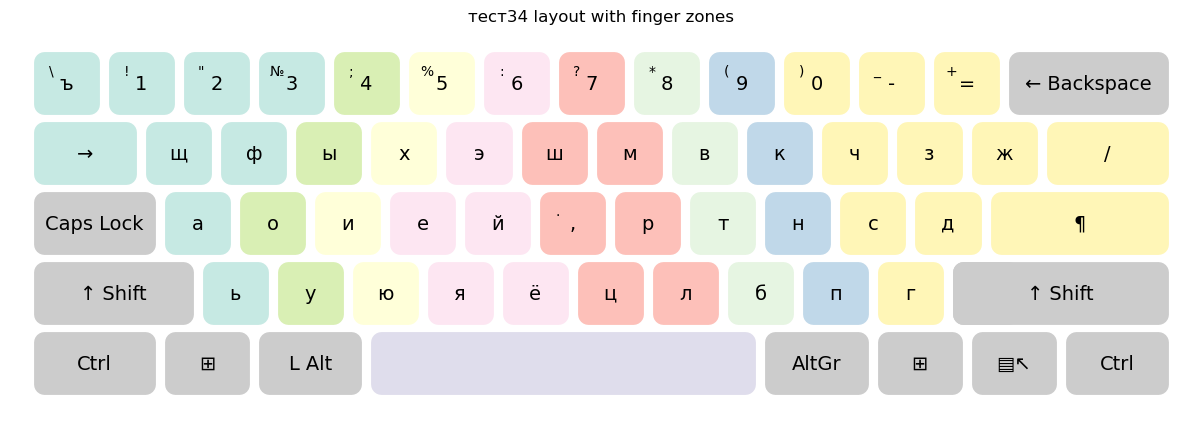

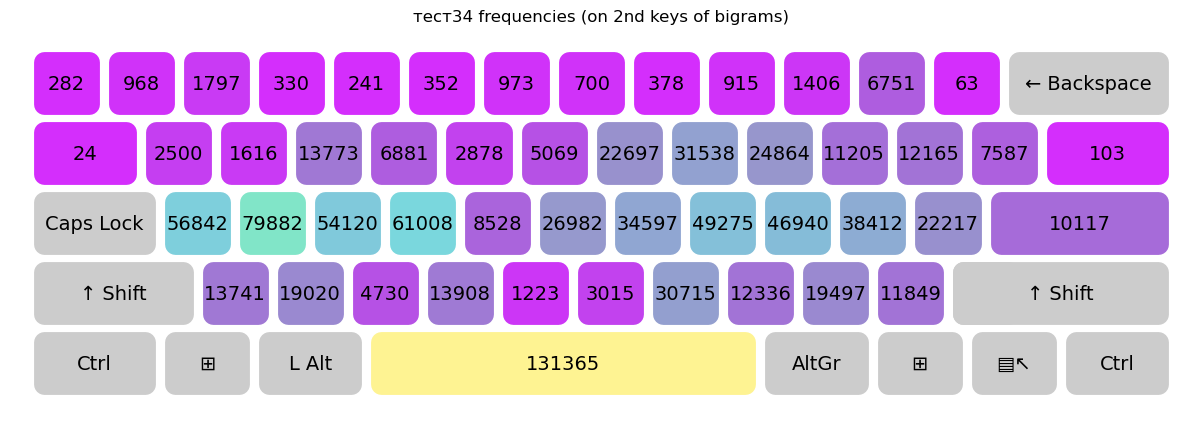

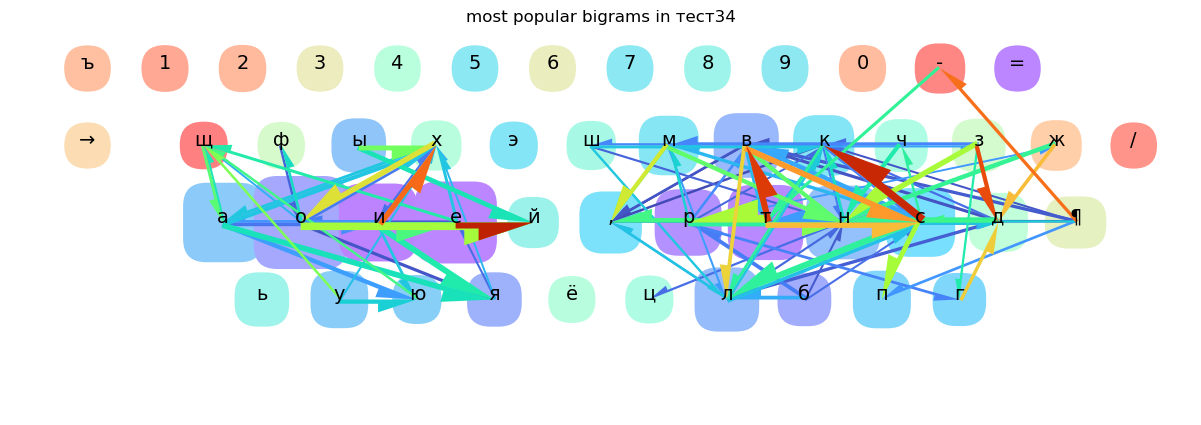

In [34]:
results['тест34'].display('layout', 'num', 'arrows')

# Comparison of best others' and mine

In [35]:
r = compare(results, 'леонов', 'тест32')
r.head(30)

bigram    num                 category_old  price_old  cost_old  \
55      по   7093                 altern hands          0         0   
38      ть   5581                 altern hands          1      5581   
40      ⌴п  13192                    space bar          2     26384   
46      ль   4283                 altern hands          1      4283   
105     на   8003                 altern hands          0         0   
177     .¶   3921                 altern hands          4     15684   
10      ра   7597                 altern hands          0         0   
94      ⌴з   3466                    space bar          2      6932   
303     па   1120                 altern hands          0         0   
66      ⌴н  11829                    space bar          0         0   
447     зд    979  in, over 1 finger, same row          2      1958   
227     ⌴д   5792                    space bar          2     11584   
194     хо   1638                 altern hands          0         0   
115     ка   5674                 altern hands          0         0   
116     аз   2695                 altern hands          2      5390   
62      то  10353                 altern hands          0         0   
92      та   4987                 altern hands          0         0   
36      ва   4893                 altern hands          0         0   
195     од   4816                 altern hands          2      9632   
53      ¶¶   4802                     same key          4     19208   
114     ск   3125                 altern hands          2      6250   
64      из   2251                 altern hands          2      4502   
291     ап    735                 altern hands          2      1470   
85      но   8706                 altern hands          0         0   
173     да   4133                 altern hands          0         0   
295     оп   1156                 altern hands          2      2312   
296     ей   2009                 altern hands          4      8036   
89      ⌴о   7499                    space bar          0         0   
465     вс   1832                 altern hands          2      3664   
60      ро   7264                 altern hands          0         0   

                category_new  price_new  cost_new  delta  
55   pinky -> ring, next row          4     28372  28372  
38              altern hands          6     33486  27905  
40                 space bar          4     52768  26384  
46              altern hands          6     25698  21415  
105             altern hands          2     16006  16006  
177           index -> pinky          8     31368  15684  
10              altern hands          2     15194  15194  
94                 space bar          6     20796  13864  
303            pinky adj row         12     13440  13440  
66                 space bar          1     11829  11829  
447            pinky adj row         14     13706  11748  
227                space bar          4     23168  11584  
194      same finger adj row          7     11466  11466  
115             altern hands          2     11348  11348  
116             altern hands          6     16170  10780  
62              altern hands          1     10353  10353  
92              altern hands          2      9974   9974  
36              altern hands          2      9786   9786  
195             altern hands          4     19264   9632  
53                  same key          6     28812   9604  
114  pinky -> ring, next row          5     15625   9375  
64              altern hands          6     13506   9004  
291            pinky adj row         14     10290   8820  
85              altern hands          1      8706   8706  
173             altern hands          2      8266   8266  
295  ring -> pinky, next row          9     10404   8092  
296      same finger adj row          8     16072   8036  
89                 space bar          1      7499   7499  
465     out, over one finger          6     10992   7328  
60              altern hands    

In [36]:
r.tail(30)

bigram   num                     category_old  price_old  cost_old  \
378     ую  1019             out, over one finger          6      6114   
394     ош   728             out, over one finger         10      7280   
190     а,  1328              same finger adj row          6      7968   
110     ки  2886                     altern hands          2      5772   
69      ор  5921                     altern hands          1      5921   
218     ше  1528          pinky -> ring, next row          4      6112   
300     и,  1600              same finger adj row          6      9600   
181     ой  3205                     altern hands          4     12820   
491     гл   645              adj finger over row         11      7095   
79      ⌴г  3298                        space bar          4     13192   
238     ас  3302                   index -> pinky          4     13208   
153     ог  3341                     altern hands          4     13364   
256     ые  1696             out, over one finger          5      8480   
155     ие  2374             out, over one finger          5     11870   
67      не  7581                     altern hands          1      7581   
33      ти  3904                     altern hands          2      7808   
252     пл   786              adj finger over row         11      8646   
129     ае  1585             out, over one finger          5      7925   
404     се  2649  in, adj finger, same or adj row          3      7947   
324     бр   812              adj finger over row         11      8932   
28      ри  4244                     altern hands          2      8488   
184     ое  1887             out, over one finger          5      9435   
78      тр  3288             out, over one finger          5     16440   
7       ли  5507                     altern hands          2     11014   
31      кр  1386              adj finger over row         11     15246   
15      ни  7156                     altern hands          2     14312   
61      ес  4129             out, over one finger          6     24774   
41      пр  6010  in, adj finger, same or adj row          3     18030   
23      ⌴и  9284                        space bar          2     18568   
56      ос  5489             out, over one finger          6     32934   

                        category_new  price_new  cost_new  delta  
378      in, over 1 finger, same row          1      1019  -5095  
394                     altern hands          3      2184  -5096  
190                     altern hands          2      2656  -5312  
110                     altern hands          0         0  -5772  
69                      altern hands          0         0  -5921  
218                     altern hands          0         0  -6112  
300                     altern hands          2      3200  -6400  
181      in, over 1 finger, same row          2      6410  -6410  
491      in, over 1 finger, same row          1       645  -6450  
79                         space bar          2      6596  -6596  
238                     altern hands          2      6604  -6604  
153                     altern hands          2      6682  -6682  
256       in, over 1 finger, adj row          1      1696  -6784  
155  in, adj finger, same or adj row          2      4748  -7122  
67                      altern hands          0         0  -7581  
33                      altern hands          0         0  -7808  
252                     altern hands          1       786  -7860  
129      in, over 1 finger, same row          0         0  -7925  
404                     altern hands          0         0  -7947  
324       in, over 1 finger, adj row          1       812  -8120  
28                      altern hands          0         0  -8488  
184      in, over 1 finger, same row          0         0  -9435  
78   in, adj finger, same or adj row          2      6576  -9864  
7                       altern hands          0         0 -11014  
31        in, over 1 finger, adj r

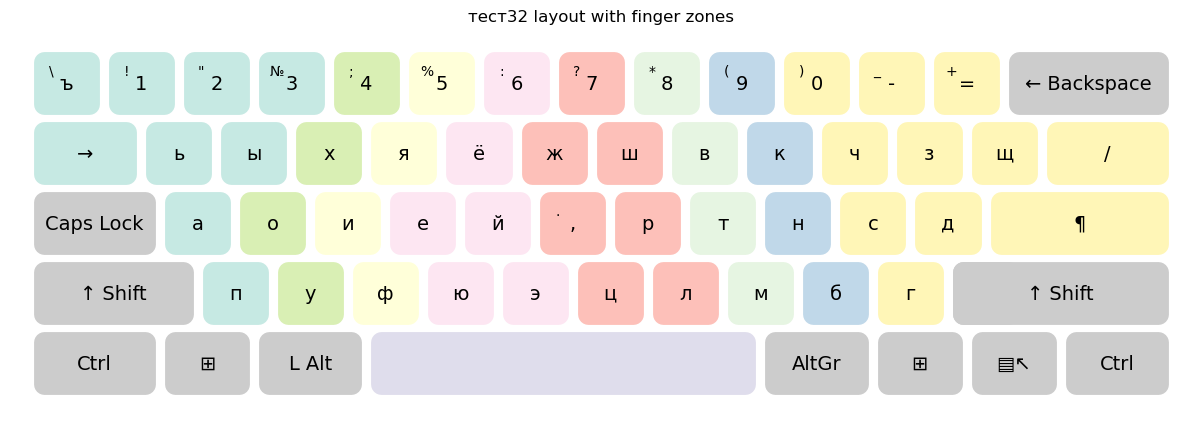

In [37]:
results['тест32'].layout.display()

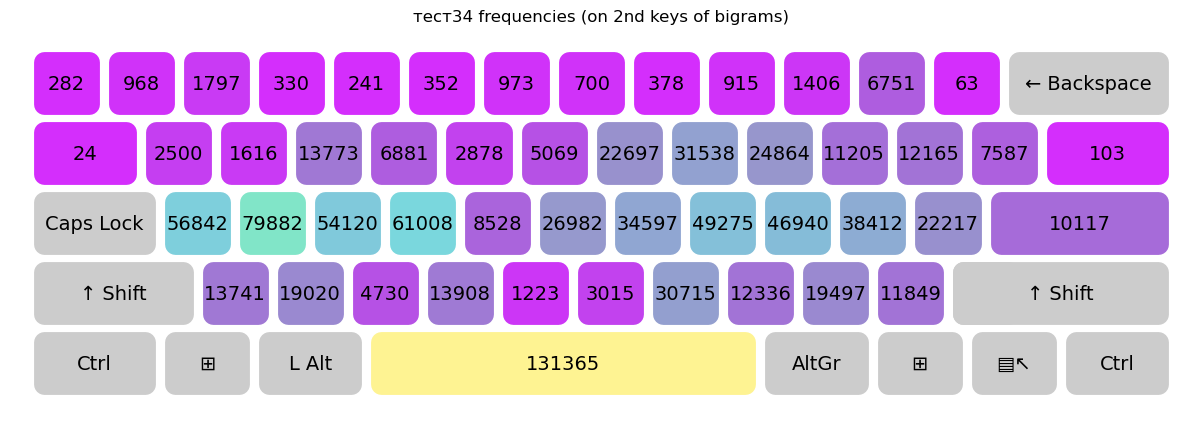

In [38]:
results['тест34'].display('nums')

<AxesSubplot: xlabel='finger'>

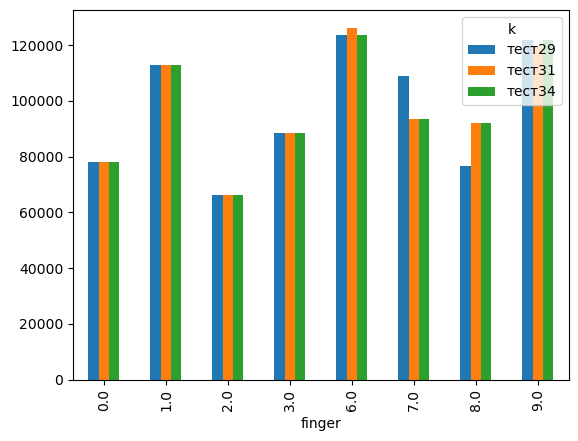

In [39]:
dfs = []
for k in ('тест29', 'тест31', 'тест34'):
    d = results[k].bigrams
    d = d[d.finger != 4].groupby('finger').agg({'num': 'sum'})
    d['k'] = k
    dfs.append(d)
x = pd.concat(dfs)

x.pivot_table('num', 'k', 'finger').T.plot.bar()

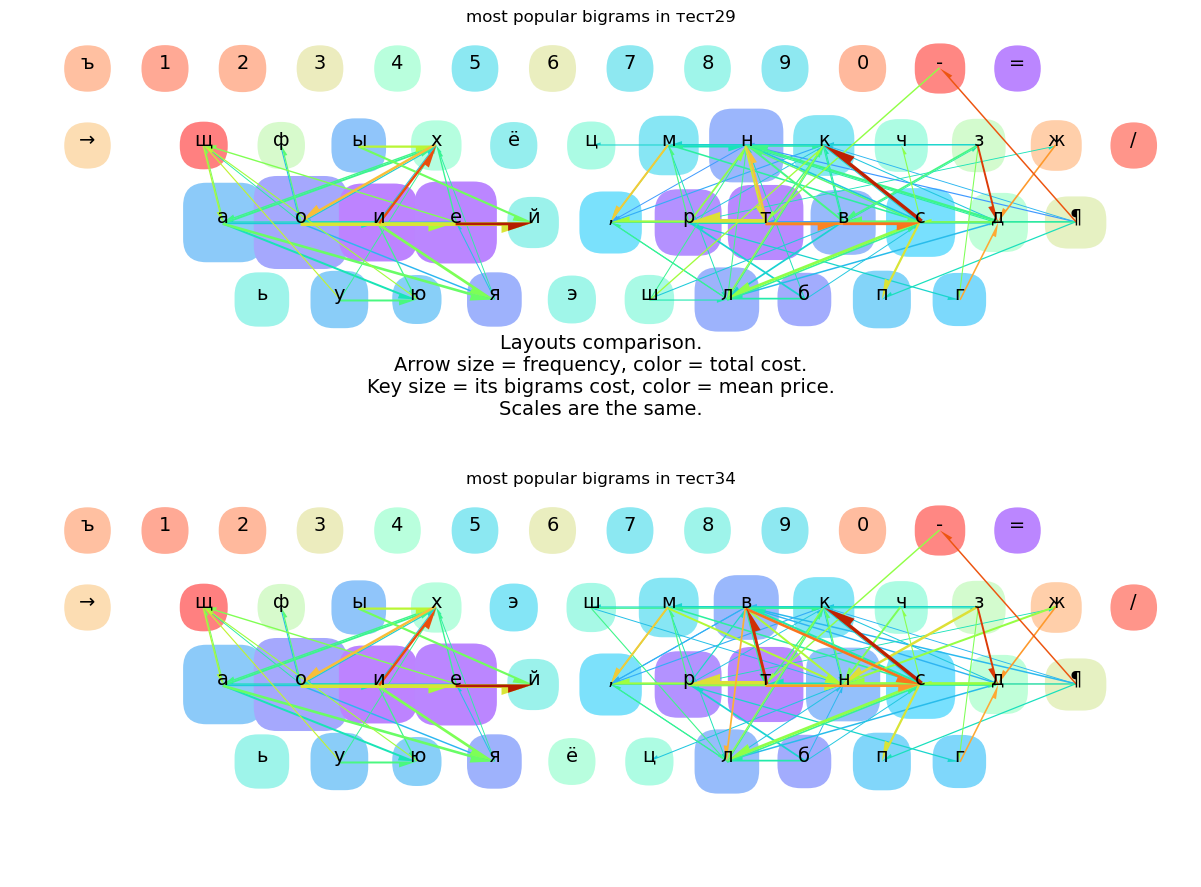

In [40]:
results['тест29'].combomap(results['тест34'])

In [41]:
results['тест37'].layout.export()


	default partial alphanumeric_keys
	xkb_symbols "v37" {
		include "ru(common)"
		name[Group1]= "Culebron (тест37)";
			key <TLDE> { [ Cyrillic_hardsign, Cyrillic_HARDSIGN, backslash ] };
	key <AE01> { [ 1, exclam ] };
	key <AE02> { [ 2, quotedbl ] };
	key <AE03> { [ 3, numerosign ] };
	key <AE04> { [ 4, semicolon ] };
	key <AE05> { [ 5, percent ] };
	key <AE06> { [ 6, colon ] };
	key <AE07> { [ 7, question ] };
	key <AE08> { [ 8, asterisk ] };
	key <AE09> { [ 9, parenleft ] };
	key <AE10> { [ 0, parenright ] };
	key <AE11> { [ minus, underscore ] };
	key <AE12> { [ equal, plus ] };
	key <AD01> { [ Cyrillic_ef, Cyrillic_EF ] };
	key <AD02> { [ Cyrillic_tse, Cyrillic_TSE ] };
	key <AD03> { [ Cyrillic_yeru, Cyrillic_YERU ] };
	key <AD04> { [ Cyrillic_ha, Cyrillic_HA ] };
	key <AD05> { [ Cyrillic_io, Cyrillic_IO ] };
	key <AD06> { [ Cyrillic_sha, Cyrillic_SHA ] };
	key <AD07> { [ Cyrillic_em, Cyrillic_EM ] };
	key <AD08> { [ Cyrillic_ve, Cyrillic_VE ] };
	key <AD09> { [ Cyrillic_ka, Cyril